### Image --> LAI 

Data

Image path: ../Data/images/A2_1_par_57_Lataule_0613.jpg


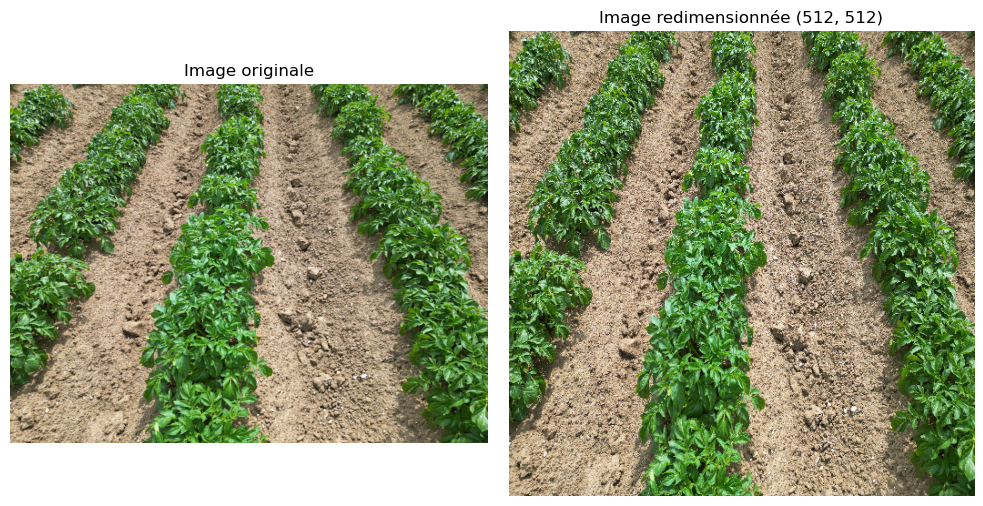

In [74]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Sélectionner un chemin d'image aléatoire
random_index = random.randint(0, len(image_paths) - 1)
img_path = image_paths[random_index]
print("Image path:", img_path)

# Lire l'image originale
image_raw = tf.io.read_file(img_path)
image_original = tf.image.decode_jpeg(image_raw, channels=3)

# Redimensionner l'image
image_resized = tf.image.resize(image_original, IMAGE_SIZE)

# Afficher les deux images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_original.numpy().astype("uint8"))
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_resized.numpy().astype("uint8"))
plt.title(f"Image redimensionnée {IMAGE_SIZE}")
plt.axis('off')

plt.tight_layout()
plt.show()


In [75]:
import pandas as pd

# Load your CSV (adjust path if needed)
df = pd.read_csv('../Data/label.csv')

# Assuming the column is named 'lai_full'
lai_values = df['lai_full'].values

# Get min and max
lai_min = lai_values.min()
lai_max = lai_values.max()

print(f"LAI Interval: [{lai_min}, {lai_max}]")


LAI Interval: [0.3783829078966872, 6.202618003482486]


In [76]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

# --- Parameters ---
IMAGE_SIZE = (512, 512)  
BATCH_SIZE = 16
EPOCHS = 500

# --- Load CSV ---
df = pd.read_csv('../Data/label.csv')  # Update if needed
image_dir = '../Data/images'           # Directory containing image files

# --- Handle image paths ---
def resolve_image_path(p):
    p = str(p).replace('\\', '/')
    if os.path.isabs(p) and os.path.exists(p):  # Full valid path
        return p
    else:  # Likely just a filename or relative path
        return os.path.join(image_dir, os.path.basename(p))

df['image_path'] = df['img_path'].apply(resolve_image_path)
image_paths = df['image_path'].values
lai_values = df['lai_full'].values.astype('float32')

# --- Check if image files exist (optional but useful debug step) ---
missing = [p for p in image_paths if not os.path.exists(p)]
if missing:
    print("Missing image files:")
    for m in missing:
        print("  ", m)
    raise FileNotFoundError("Some image files are missing. Fix paths before training.")

# --- Train/Test Split ---
train_paths, test_paths, train_lai, test_lai = train_test_split(
    image_paths, lai_values, test_size=0.1, random_state=42
)
train_paths, val_paths, train_lai, val_lai = train_test_split(
    train_paths, train_lai, test_size=0.2, random_state=42
)

# --- Preprocessing Function ---
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize
    return image, label

# --- Create tf.data.Dataset ---
def make_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_img = make_dataset(train_paths, train_lai)
val_ds_img = make_dataset(val_paths, val_lai)
test_ds_img=make_dataset(test_paths,test_lai)

Model 1: des couches simple de convolution  

In [84]:
# --- Model Architecture ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D

inputs = Input(shape=(512, 512, 3))


x = Conv2D(45, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(90, (3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(180, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(180)(x)
x = ReLU()(x)
x = BatchNormalization()(x)


x = Dropout(0.5)(x)
x = Dense(90)(x)
x = ReLU()(x)

output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.summary()

# --- Compile ---
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- Train ---
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_ds_img, validation_data=val_ds_img, epochs=EPOCHS, callbacks=[early_stop])

# --- Save model ---
model.save('lai_prediction_model.h5')


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 512, 512, 45)   │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_70 (ReLU)                 │ (None, 512, 512, 45)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 512, 512, 45)   │           180 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 256, 256, 45)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 256, 256, 90)   │        36,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_71 (ReLU)                 │ (None, 256, 256, 90)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 256, 256, 90)   │           360 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 128, 128, 90)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 128, 128, 180)  │       145,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_72 (ReLU)                 │ (None, 128, 128, 180)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 128, 128, 180)  │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 64, 64, 180)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 180)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 180)            │        32,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_73 (ReLU)                 │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 180)            │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 90)             │        16,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_74 (ReLU)                 │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,721 (916.88 KB)

 Trainable params: 233,731 (913.01 KB)

 Non-trainable params: 990 (3.87 KB)

Epoch 1/500


2025-08-06 12:10:06.931719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 512 of 1000
2025-08-06 12:10:11.885460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - loss: 8.7405 - mae: 2.6134 - val_loss: 8.4036 - val_mae: 2.5510
Epoch 2/500


2025-08-06 12:14:22.510613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 485 of 1000
2025-08-06 12:14:28.559570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - loss: 2.9136 - mae: 1.4043 - val_loss: 5.8453 - val_mae: 2.0296
Epoch 3/500


2025-08-06 12:18:36.758791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 511 of 1000
2025-08-06 12:18:42.010902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - loss: 1.7649 - mae: 1.0569 - val_loss: 4.0563 - val_mae: 1.6572
Epoch 4/500


2025-08-06 12:22:43.803488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 460 of 1000
2025-08-06 12:22:50.779442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - loss: 1.4169 - mae: 0.9360 - val_loss: 2.2760 - val_mae: 1.2291
Epoch 5/500


2025-08-06 12:27:00.252638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 485 of 1000
2025-08-06 12:27:06.051560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - loss: 1.3645 - mae: 0.9054 - val_loss: 1.9369 - val_mae: 1.1260
Epoch 6/500


2025-08-06 12:31:16.457615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 491 of 1000
2025-08-06 12:31:22.031494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - loss: 1.0511 - mae: 0.7704 - val_loss: 1.7039 - val_mae: 1.0621
Epoch 7/500


2025-08-06 12:35:23.662342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 520 of 1000
2025-08-06 12:35:28.571276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 1.2329 - mae: 0.8802 - val_loss: 1.9447 - val_mae: 1.1501
Epoch 8/500


2025-08-06 12:39:22.205857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 506 of 1000
2025-08-06 12:39:27.368484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.9780 - mae: 0.7740 - val_loss: 3.3234 - val_mae: 1.5423
Epoch 9/500


2025-08-06 12:43:19.829505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 481 of 1000
2025-08-06 12:43:26.153493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - loss: 1.0280 - mae: 0.7779 - val_loss: 3.6127 - val_mae: 1.6317
Epoch 10/500


2025-08-06 12:47:18.901027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 499 of 1000
2025-08-06 12:47:24.273993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 1.0161 - mae: 0.8221 - val_loss: 4.3588 - val_mae: 1.8297
Epoch 11/500


2025-08-06 12:51:16.641546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 484 of 1000
2025-08-06 12:51:22.283986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.9405 - mae: 0.7551 - val_loss: 2.5922 - val_mae: 1.4117
Epoch 12/500


2025-08-06 12:55:14.218767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 508 of 1000
2025-08-06 12:55:19.843028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.9777 - mae: 0.7713 - val_loss: 1.7557 - val_mae: 1.1629
Epoch 13/500


2025-08-06 12:59:11.366834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 505 of 1000
2025-08-06 12:59:16.936468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.9057 - mae: 0.7314 - val_loss: 1.8056 - val_mae: 1.0999
Epoch 14/500


2025-08-06 13:03:09.475932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 487 of 1000
2025-08-06 13:03:15.647848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.7958 - mae: 0.6801 - val_loss: 1.2816 - val_mae: 0.9636
Epoch 15/500


2025-08-06 13:07:06.776988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 495 of 1000
2025-08-06 13:07:12.105620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.7739 - mae: 0.6943 - val_loss: 0.7322 - val_mae: 0.7233
Epoch 16/500


2025-08-06 13:11:04.537344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 500 of 1000
2025-08-06 13:11:09.894574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - loss: 0.7236 - mae: 0.6740 - val_loss: 0.2910 - val_mae: 0.4141
Epoch 17/500


2025-08-06 13:15:00.904394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 467 of 1000
2025-08-06 13:15:07.259383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - loss: 0.6731 - mae: 0.6491 - val_loss: 0.3956 - val_mae: 0.5197
Epoch 18/500


2025-08-06 13:18:59.484418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 490 of 1000
2025-08-06 13:19:05.056938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.8682 - mae: 0.7351 - val_loss: 0.4337 - val_mae: 0.5365
Epoch 19/500


2025-08-06 13:22:57.477135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 506 of 1000
2025-08-06 13:23:03.208800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - loss: 0.8359 - mae: 0.7073 - val_loss: 0.2442 - val_mae: 0.4029
Epoch 20/500


2025-08-06 13:26:56.047318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 496 of 1000
2025-08-06 13:27:01.626288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.7302 - mae: 0.6526 - val_loss: 0.3823 - val_mae: 0.5275
Epoch 21/500


2025-08-06 13:30:54.170279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 502 of 1000
2025-08-06 13:30:59.358065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - loss: 0.6590 - mae: 0.6540 - val_loss: 0.2714 - val_mae: 0.4219
Epoch 22/500


2025-08-06 13:34:50.443323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 511 of 1000
2025-08-06 13:34:55.874764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.6526 - mae: 0.6472 - val_loss: 0.3018 - val_mae: 0.3900
Epoch 23/500


2025-08-06 13:38:47.854296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 495 of 1000
2025-08-06 13:38:53.185381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.5364 - mae: 0.5889 - val_loss: 0.3944 - val_mae: 0.4337
Epoch 24/500


2025-08-06 13:42:45.756666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 524 of 1000
2025-08-06 13:42:50.504328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.6117 - mae: 0.6183 - val_loss: 0.3636 - val_mae: 0.4157
Epoch 25/500


2025-08-06 13:46:42.292127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 513 of 1000
2025-08-06 13:46:47.603083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.5841 - mae: 0.6049 - val_loss: 0.5556 - val_mae: 0.5433
Epoch 26/500


2025-08-06 13:50:38.844506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 492 of 1000
2025-08-06 13:50:44.392759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.4786 - mae: 0.5320 - val_loss: 0.2044 - val_mae: 0.3630
Epoch 27/500


2025-08-06 13:54:36.471373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 503 of 1000
2025-08-06 13:54:41.799712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.4809 - mae: 0.5395 - val_loss: 0.4294 - val_mae: 0.5290
Epoch 28/500


2025-08-06 13:58:34.016744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 503 of 1000
2025-08-06 13:58:39.500881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - loss: 0.5539 - mae: 0.5818 - val_loss: 0.3560 - val_mae: 0.4388
Epoch 29/500


2025-08-06 14:02:31.229788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 515 of 1000
2025-08-06 14:02:36.210578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.6283 - mae: 0.6054 - val_loss: 0.2949 - val_mae: 0.3886
Epoch 30/500


2025-08-06 14:06:28.742160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 480 of 1000
2025-08-06 14:06:34.798511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 0.4565 - mae: 0.5187 - val_loss: 0.2493 - val_mae: 0.3358
Epoch 31/500


2025-08-06 14:10:26.376147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 524 of 1000
2025-08-06 14:10:31.688759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - loss: 0.6154 - mae: 0.6123 - val_loss: 0.2520 - val_mae: 0.3263
Epoch 32/500


2025-08-06 14:14:30.182614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 506 of 1000
2025-08-06 14:14:35.414261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - loss: 0.4992 - mae: 0.5602 - val_loss: 0.3506 - val_mae: 0.4368
Epoch 33/500


2025-08-06 14:18:38.872046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 498 of 1000
2025-08-06 14:18:44.241729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - loss: 0.4755 - mae: 0.5302 - val_loss: 0.3651 - val_mae: 0.3447
Epoch 34/500


2025-08-06 14:22:47.121446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 496 of 1000
2025-08-06 14:22:52.591541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - loss: 0.4757 - mae: 0.5420 - val_loss: 0.5279 - val_mae: 0.3910
Epoch 35/500


2025-08-06 14:26:51.822055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 482 of 1000
2025-08-06 14:26:57.486317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - loss: 0.5165 - mae: 0.5656 - val_loss: 0.4624 - val_mae: 0.3812
Epoch 36/500


2025-08-06 14:30:58.300562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 513 of 1000
2025-08-06 14:31:04.024601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - loss: 0.5445 - mae: 0.5617 - val_loss: 0.3599 - val_mae: 0.3177


In [85]:
# Best (lowest) training MAE and loss
best_train_mae = min(history.history['mae'])
best_train_loss = min(history.history['loss'])

# Best (lowest) validation MAE and loss
best_val_mae = min(history.history['val_mae'])
best_val_loss = min(history.history['val_loss'])

print(f"Best Train MAE: {best_train_mae:.4f}")
print(f"Best Train Loss (MSE): {best_train_loss:.4f}")
print(f"Best Val MAE: {best_val_mae:.4f}")
print(f"Best Val Loss (MSE): {best_val_loss:.4f}")


Best Train MAE: 0.5335
Best Train Loss (MSE): 0.4752
Best Val MAE: 0.3177
Best Val Loss (MSE): 0.2044


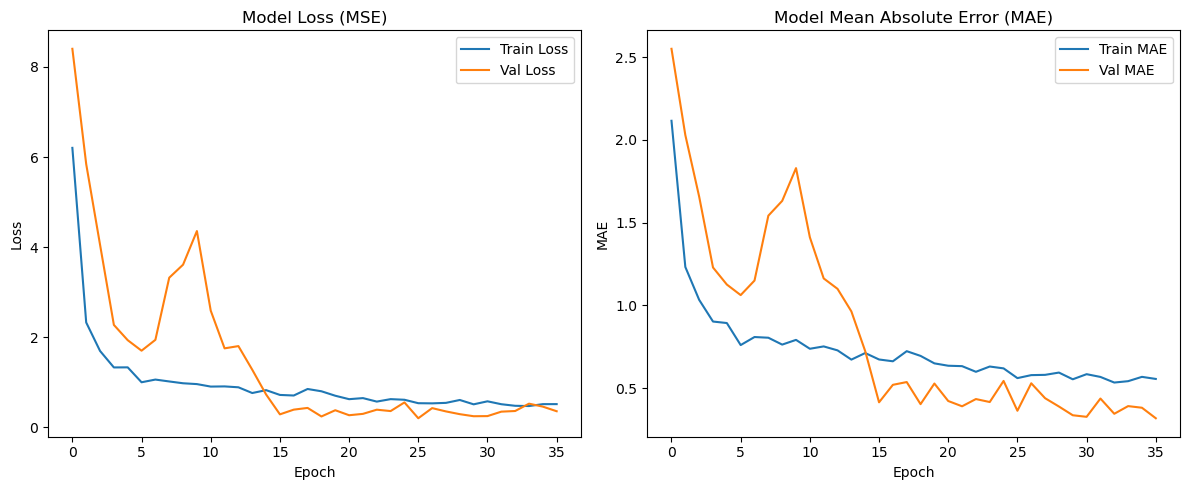

In [86]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


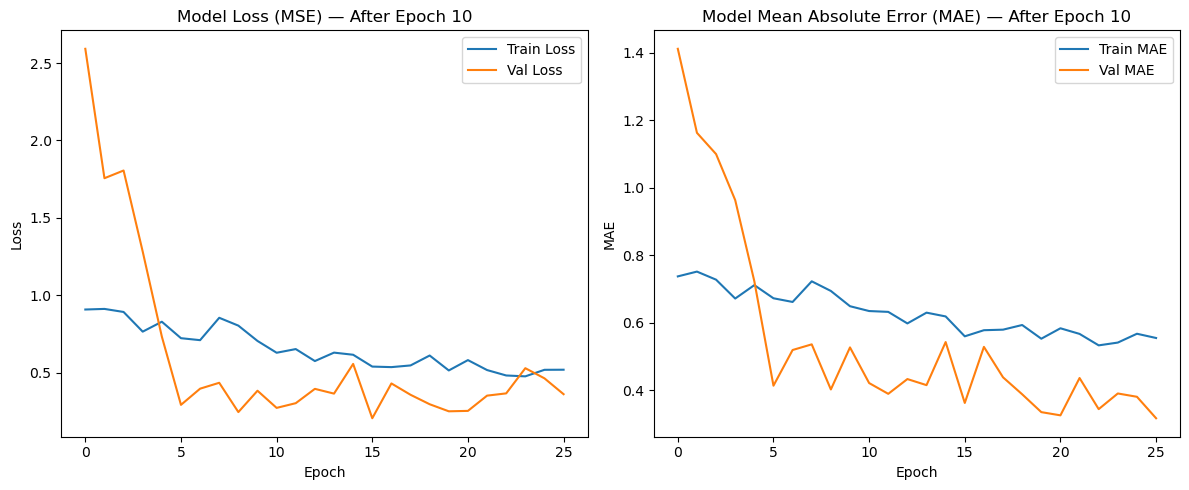

In [87]:
import matplotlib.pyplot as plt

# Plot training & validation loss and MAE values after epoch 10
start_epoch = 10

plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][start_epoch:], label='Train Loss')
plt.plot(history.history['val_loss'][start_epoch:], label='Val Loss')
plt.title('Model Loss (MSE) — After Epoch 10')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'][start_epoch:], label='Train MAE')
plt.plot(history.history['val_mae'][start_epoch:], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE) — After Epoch 10')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


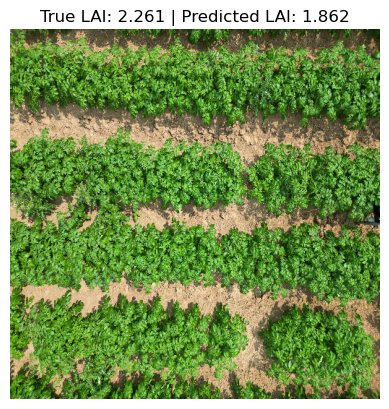

In [88]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Pick a random index
idx = random.randint(0, len(val_paths) - 1)
img_path = val_paths[idx]
true_lai = val_lai[idx]

# Load and preprocess the image
image = tf.io.read_file(img_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (512, 512))
image = image / 255.0  # Normalize
image_batch = tf.expand_dims(image, axis=0)  # Add batch dimension

# Predict
pred_lai = model.predict(image_batch)[0][0]  # Extract scalar from prediction

# Show the image
plt.imshow(image)
plt.title(f"True LAI: {true_lai:.3f} | Predicted LAI: {pred_lai:.3f}")
plt.axis('off')
plt.show()


In [89]:
# Evaluate the model
test_loss, test_mae = model.evaluate(test_ds_img)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - loss: 0.1930 - mae: 0.3420
Test Loss (MSE): 0.2074
Test MAE: 0.3660


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


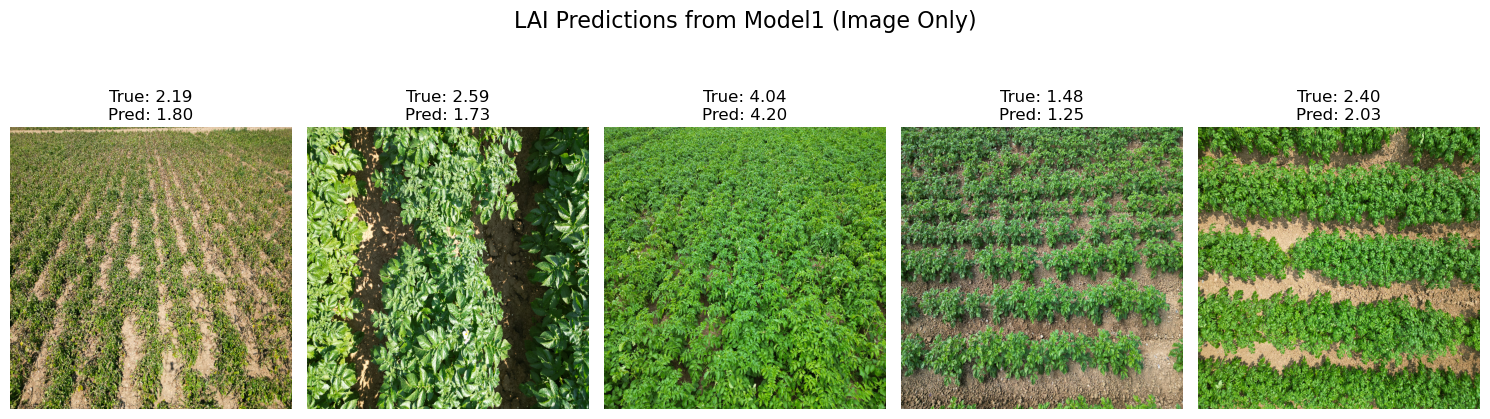

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Unbatch the dataset to access individual samples
test_ds_img_unbatched = test_ds_img.unbatch()

# Number of samples to display
num_samples = 5

# Storage
images = []
true_lai = []

# Collect N samples
for x, y in test_ds_img_unbatched.take(num_samples):
    images.append(x.numpy())
    true_lai.append(y.numpy())

images = np.array(images)
true_lai = np.array(true_lai).flatten()

# Predict using model1
predicted_lai = model.predict(images).flatten()

# Plot
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {true_lai[i]:.2f}\nPred: {predicted_lai[i]:.2f}")

plt.suptitle("LAI Predictions from Model", fontsize=16)
plt.tight_layout()
plt.show()


In [136]:
from sklearn.metrics import r2_score
import numpy as np

# Extraire les vraies valeurs
true_values = np.concatenate([y for x, y in test_ds_img], axis=0).flatten()

# Prédictions du modèle
predictions = model.predict(test_ds_img).flatten()

# Calcul du R²
r2 = r2_score(true_values, predictions)
print(f"R² (R-squared): {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 676ms/step
R² (R-squared): -0.9675


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Model 2: MobileNet V2 

In [92]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Parameters ---
IMAGE_SIZE = (512, 512)
EPOCHS = 500
LR = 1e-4

# --- Backbone MobileNetV2 ---
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')  # Pre-trained weights

base_model.trainable = False  # Freeze weights

# --- Build Model ---
inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # instead of Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model1 = Model(inputs, output)
model1.summary()

# --- Compile ---
optimizer = Adam(learning_rate=LR)
model1.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- Train ---

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history1 = model1.fit(train_ds_img,
                    validation_data=val_ds_img,
                    epochs=EPOCHS,
                    callbacks=[early_stop])

# --- Save ---
model1.save('lai_transfer_mobilenetv2.h5')


/tmp/ipykernel_1576946/2033209755.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 16, 16, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602,433 (9.93 MB)

 Trainable params: 344,449 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/500


2025-08-06 14:35:23.245774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 484 of 1000
2025-08-06 14:35:28.854939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 4.6750 - mae: 1.6209 - val_loss: 0.3414 - val_mae: 0.4448
Epoch 2/500


2025-08-06 14:36:34.878225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 541 of 1000
2025-08-06 14:36:39.773742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.9058 - mae: 0.7454 - val_loss: 0.2496 - val_mae: 0.3758
Epoch 3/500


2025-08-06 14:37:44.954601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 505 of 1000
2025-08-06 14:37:50.407345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.7325 - mae: 0.6563 - val_loss: 0.2178 - val_mae: 0.3470
Epoch 4/500


2025-08-06 14:38:55.142990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 519 of 1000
2025-08-06 14:39:00.023835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.5191 - mae: 0.5624 - val_loss: 0.2084 - val_mae: 0.3402
Epoch 5/500


2025-08-06 14:40:07.705760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 494 of 1000
2025-08-06 14:40:13.890249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.5353 - mae: 0.5745 - val_loss: 0.2066 - val_mae: 0.3552
Epoch 6/500


2025-08-06 14:41:19.140855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 511 of 1000
2025-08-06 14:41:24.109421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.4939 - mae: 0.5466 - val_loss: 0.1616 - val_mae: 0.3069
Epoch 7/500


2025-08-06 14:42:30.390481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 506 of 1000
2025-08-06 14:42:36.086383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.3967 - mae: 0.4802 - val_loss: 0.2092 - val_mae: 0.3669
Epoch 8/500


2025-08-06 14:43:43.006152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 513 of 1000
2025-08-06 14:43:47.944672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.4078 - mae: 0.5033 - val_loss: 0.1365 - val_mae: 0.2874
Epoch 9/500


2025-08-06 14:44:54.031616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 514 of 1000
2025-08-06 14:44:58.954843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.3925 - mae: 0.4843 - val_loss: 0.2304 - val_mae: 0.3922
Epoch 10/500


2025-08-06 14:46:05.533262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 494 of 1000
2025-08-06 14:46:11.418996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.3639 - mae: 0.4623 - val_loss: 0.1497 - val_mae: 0.3008
Epoch 11/500


2025-08-06 14:47:17.947301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 484 of 1000
2025-08-06 14:47:24.445791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.3131 - mae: 0.4383 - val_loss: 0.1421 - val_mae: 0.2966
Epoch 12/500


2025-08-06 14:48:30.874970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 520 of 1000
2025-08-06 14:48:36.012176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.3425 - mae: 0.4709 - val_loss: 0.1385 - val_mae: 0.2934
Epoch 13/500


2025-08-06 14:49:42.169509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 497 of 1000
2025-08-06 14:49:48.094477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.2913 - mae: 0.4135 - val_loss: 0.1963 - val_mae: 0.3561
Epoch 14/500


2025-08-06 14:50:53.830502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 503 of 1000
2025-08-06 14:50:58.897397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.3159 - mae: 0.4348 - val_loss: 0.1307 - val_mae: 0.2868
Epoch 15/500


2025-08-06 14:52:05.196161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 500 of 1000
2025-08-06 14:52:10.546305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.2613 - mae: 0.3923 - val_loss: 0.1245 - val_mae: 0.2784
Epoch 16/500


2025-08-06 14:53:16.691096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 533 of 1000
2025-08-06 14:53:21.577034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.2774 - mae: 0.4053 - val_loss: 0.1848 - val_mae: 0.3498
Epoch 17/500


2025-08-06 14:54:27.247742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 487 of 1000
2025-08-06 14:54:32.852076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.2644 - mae: 0.4065 - val_loss: 0.1562 - val_mae: 0.3191
Epoch 18/500


2025-08-06 14:55:38.453118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 498 of 1000
2025-08-06 14:55:44.404987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.2235 - mae: 0.3725 - val_loss: 0.2836 - val_mae: 0.4526
Epoch 19/500


2025-08-06 14:56:51.560768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 503 of 1000
2025-08-06 14:56:57.273534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.2464 - mae: 0.3747 - val_loss: 0.1575 - val_mae: 0.3263
Epoch 20/500


2025-08-06 14:58:03.990972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 511 of 1000
2025-08-06 14:58:09.299288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.2549 - mae: 0.3833 - val_loss: 0.1363 - val_mae: 0.2967
Epoch 21/500


2025-08-06 14:59:15.628364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 533 of 1000
2025-08-06 14:59:20.357788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.2288 - mae: 0.3579 - val_loss: 0.1934 - val_mae: 0.3678
Epoch 22/500


2025-08-06 15:00:27.347770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 518 of 1000
2025-08-06 15:00:32.321259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.2500 - mae: 0.3833 - val_loss: 0.2172 - val_mae: 0.3845
Epoch 23/500


2025-08-06 15:01:38.608366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 506 of 1000
2025-08-06 15:01:44.088797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.2223 - mae: 0.3632 - val_loss: 0.1255 - val_mae: 0.2815
Epoch 24/500


2025-08-06 15:02:50.721793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 514 of 1000
2025-08-06 15:02:56.241277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.2078 - mae: 0.3563 - val_loss: 0.1389 - val_mae: 0.2950
Epoch 25/500


2025-08-06 15:04:03.642719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:172: Filling up shuffle buffer (this may take a while): 496 of 1000
2025-08-06 15:04:09.140400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.2284 - mae: 0.3607 - val_loss: 0.1527 - val_mae: 0.3166


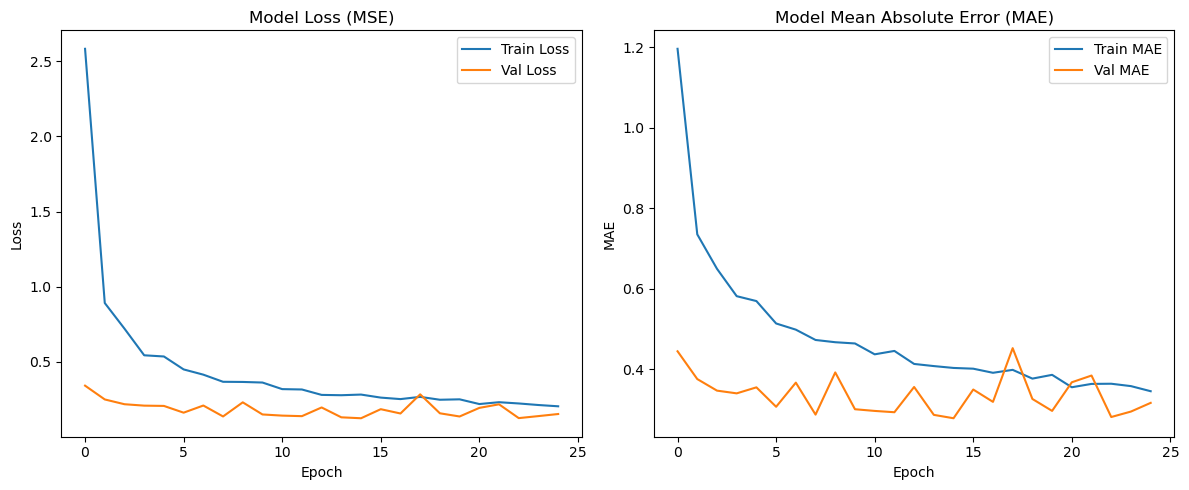

In [93]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history1.history['mae'], label='Train MAE')
plt.plot(history1.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


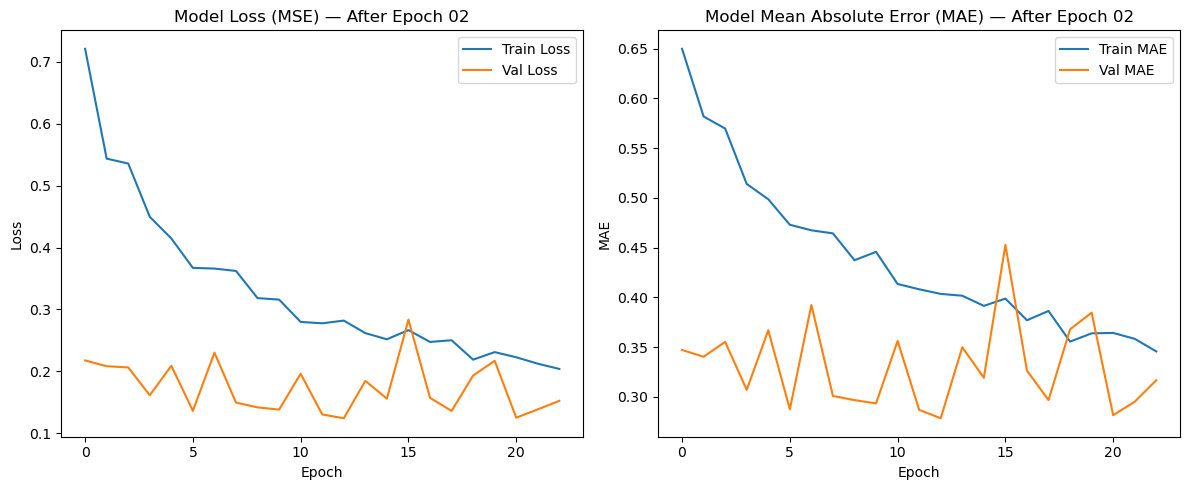

In [94]:
import matplotlib.pyplot as plt

# Plot training & validation loss and MAE values after epoch 10
start_epoch = 2

plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'][start_epoch:], label='Train Loss')
plt.plot(history1.history['val_loss'][start_epoch:], label='Val Loss')
plt.title('Model Loss (MSE) — After Epoch 02')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history1.history['mae'][start_epoch:], label='Train MAE')
plt.plot(history1.history['val_mae'][start_epoch:], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE) — After Epoch 02')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [95]:
# Best (lowest) training MAE and loss
best_train_mae = min(history1.history['mae'])
best_train_loss = min(history1.history['loss'])

# Best (lowest) validation MAE and loss
best_val_mae = min(history1.history['val_mae'])
best_val_loss = min(history1.history['val_loss'])

print(f"Best Train MAE: {best_train_mae:.4f}")
print(f"Best Train Loss (MSE): {best_train_loss:.4f}")
print(f"Best Val MAE: {best_val_mae:.4f}")
print(f"Best Val Loss (MSE): {best_val_loss:.4f}")


Best Train MAE: 0.3456
Best Train Loss (MSE): 0.2041
Best Val MAE: 0.2784
Best Val Loss (MSE): 0.1245


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


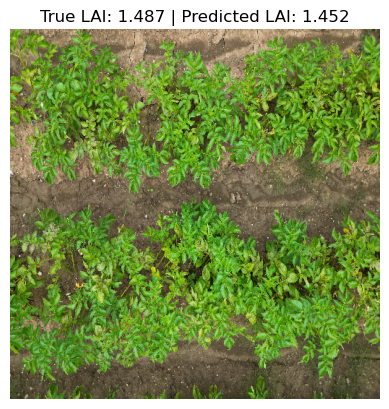

In [96]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Pick a random index
idx = random.randint(0, len(val_paths) - 1)
img_path = val_paths[idx]
true_lai = val_lai[idx]

# Load and preprocess the image
image = tf.io.read_file(img_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (512, 512))
image = image / 255.0  # Normalize
image_batch = tf.expand_dims(image, axis=0)  # Add batch dimension

# Predict
pred_lai = model1.predict(image_batch)[0][0]  # Extract scalar from prediction

# Show the image
plt.imshow(image)
plt.title(f"True LAI: {true_lai:.3f} | Predicted LAI: {pred_lai:.3f}")
plt.axis('off')
plt.show()


In [132]:
# Evaluate the model
test_loss, test_mae = model1.evaluate(test_ds_img)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 854ms/step - loss: 0.1564 - mae: 0.3025
Test Loss (MSE): 0.1671
Test MAE: 0.3151


2025-08-06 16:28:54.974136: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


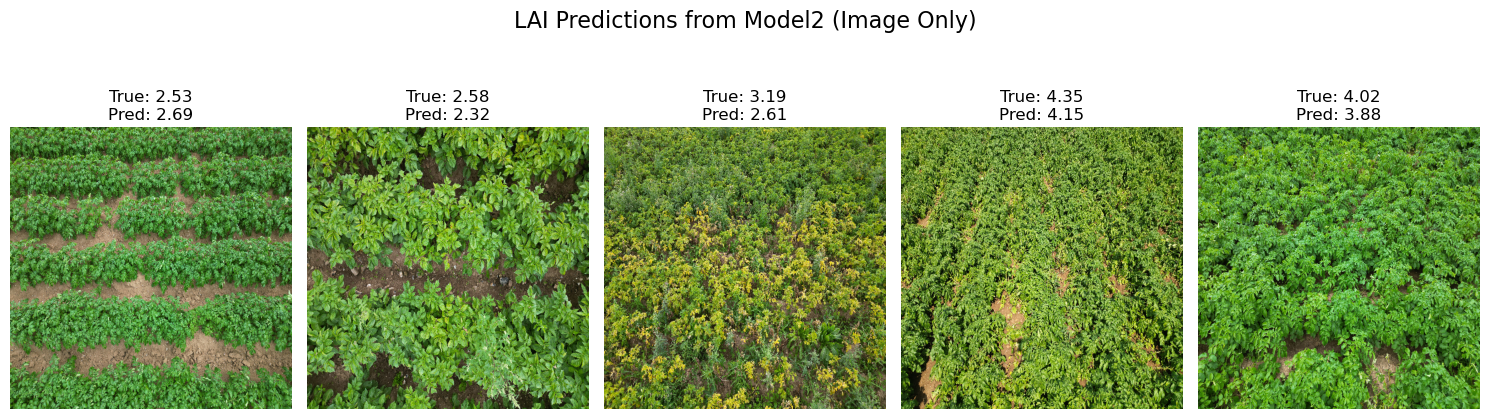

In [115]:
import numpy as np
import matplotlib.pyplot as plt

# Unbatch the dataset to access individual samples
test_ds_img_unbatched = test_ds_img.unbatch()

# Number of samples to display
num_samples = 5

# Storage
images = []
true_lai = []

# Collect N samples
for x, y in test_ds_img_unbatched.take(num_samples):
    images.append(x.numpy())
    true_lai.append(y.numpy())

images = np.array(images)
true_lai = np.array(true_lai).flatten()

# Predict using model1
predicted_lai = model1.predict(images).flatten()

# Plot
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {true_lai[i]:.2f}\nPred: {predicted_lai[i]:.2f}")

plt.suptitle("LAI Predictions from Model2 (Image Only)", fontsize=16)
plt.tight_layout()
plt.show()


In [137]:
from sklearn.metrics import r2_score
import numpy as np

#Extraire les vraies valeurs
true_values = np.concatenate([y for x, y in test_ds_img], axis=0).flatten()

# Prédictions du modèle
predictions = model1.predict(test_ds_img).flatten()

# Calcul du R²
r2 = r2_score(true_values, predictions)
print(f"R² (R-squared): {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 826ms/step
R² (R-squared): -0.7167


### mask + image --> LAI

Data

In [ ]:
import os
from PIL import Image

# Set the mask directory
mask_dir = '../Data/masks'

# Make sure the directory exists
if not os.path.exists(mask_dir):
    raise FileNotFoundError(f"Directory not found: {mask_dir}")

# Loop over files
for filename in os.listdir(mask_dir):
    if filename.lower().endswith(('.png', '.jpg', '.JPG', '.tiff')):
        input_path = os.path.join(mask_dir, filename)

        # Load and convert
        img = Image.open(input_path).convert('RGB')  # Convert to 3 channels for JPEG
        new_filename = os.path.splitext(filename)[0] + '.jpg'
        output_path = os.path.join(mask_dir, new_filename)

        # Save as JPEG
        img.save(output_path, 'JPEG', quality=95)


        print(f"Converted: {filename} → {new_filename}")


In [80]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

# --- Parameters ---
IMAGE_SIZE = (512, 512)  
BATCH_SIZE = 16
EPOCHS = 500

# --- Paths ---
df = pd.read_csv('../Data/label.csv')     # Must contain 'img_path' and 'lai_full'
image_dir = '../Data/images'
mask_dir = '../Data/masks'

# --- Construct full image path ---
def resolve_image_path(p):
    filename = os.path.basename(str(p)).replace('\\', '/')
    return os.path.join(image_dir, filename)

# --- Derive mask path from image name ---
def resolve_mask_path(p):
    filename = os.path.basename(str(p)).replace('\\', '/').replace('.jpg', '')
    parts = filename.split('_')
    
    if len(parts) < 4:
        raise ValueError(f"Unexpected filename format: {filename}")

    # Insert "_mask_" after the first three segments
    mask_filename = '_'.join(parts[:4]) + '_mask_' + '_'.join(parts[4:]) + '.jpg'
    return os.path.join(mask_dir, mask_filename)

# --- Apply path resolution ---
df['image_path'] = df['img_path'].apply(resolve_image_path)
df['mask_path'] = df['img_path'].apply(resolve_mask_path)

image_paths = df['image_path'].values
mask_paths = df['mask_path'].values
lai_values = df['lai_full'].values.astype('float32')

# --- File existence validation ---
for path_list, label in [(image_paths, "image"), (mask_paths, "mask")]:
    missing = [p for p in path_list if not os.path.exists(p)]
    if missing:
        print(f"Missing {label} files:")
        for m in missing:
            print("  ", m)
        raise FileNotFoundError(f"Some {label} files are missing. Ensure consistency in naming convention.")

# --- Train/Test Split ---
train_img, test_img, train_mask, test_mask, train_lai, test_lai = train_test_split(
    image_paths, mask_paths, lai_values, test_size=0.1, random_state=42
)
train_img, val_img, train_mask, val_mask, train_lai, val_lai = train_test_split(
    train_img, train_mask, train_lai, test_size=0.2, random_state=42
)

# --- Preprocessing for image-mask-label triple ---
def preprocess(img_path, mask_path, label):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming grayscale mask
    mask = tf.image.resize(mask, IMAGE_SIZE)
    mask = mask / 255.0  # Normalize mask to [0,1]

    return (img, mask), label

# --- Dataset factory ---
def make_dataset(img_paths, mask_paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Datasets ready for training ---
train_ds_msk = make_dataset(train_img, train_mask, train_lai)
val_ds_msk = make_dataset(val_img, val_mask, val_lai)
test_ds_msk=make_dataset(test_img,test_mask,test_lai)


Model 1: couches de convolution pour image et mask

In [71]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# --- Inputs ---
img_input = Input(shape=(512, 512, 3))
mask_input = Input(shape=(512, 512, 1))

# --- Image branch ---
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(img_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# --- Mask branch ---
m = Conv2D(16, (3, 3), padding='same')(mask_input)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2, 2))(m)  # Now 256x256

m = Conv2D(32, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2, 2))(m)  # Now 128x128

m = Conv2D(64, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2, 2))(m)  # Now 64x64 ✅ MATCH


# --- Concatenate features ---
x = concatenate([x, m])

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)

output = Dense(1, activation='linear')(x)

# --- Model ---
model2 = Model(inputs=[img_input, mask_input], outputs=output)
model2.summary()

# --- Compile ---
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- Train ---
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history2 = model2.fit(train_ds_msk, validation_data=val_ds_msk, epochs=EPOCHS, callbacks=[early_stop])


# --- Save ---
model2.save('lai_prediction_model_mask_image.h5')


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 512, 512,  │        896 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 512, 512,  │        160 │ input_layer_20[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_60 (ReLU)     │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_63 (ReLU)     │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 256, 256,  │          0 │ re_lu_60[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 256, 256,  │          0 │ re_lu_63[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 256, 256,  │     18,496 │ max_pooling2d_49… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_52… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_61 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_64 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 128, 128,  │          0 │ re_lu_61[0][0]  

 Total params: 8,625,857 (32.91 MB)

 Trainable params: 8,625,057 (32.90 MB)

 Non-trainable params: 800 (3.12 KB)

Epoch 1/500


2025-08-05 14:28:11.705255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 430 of 1000
2025-08-05 14:28:21.107844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - loss: 15.7698 - mae: 3.1289 - val_loss: 5.9014 - val_mae: 2.0298
Epoch 2/500


2025-08-05 14:32:36.418981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 433 of 1000
2025-08-05 14:32:45.762482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - loss: 3.8270 - mae: 1.5329 - val_loss: 4.8100 - val_mae: 1.8022
Epoch 3/500


2025-08-05 14:36:55.517401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 483 of 1000
2025-08-05 14:37:03.086951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - loss: 2.9486 - mae: 1.3389 - val_loss: 4.4477 - val_mae: 1.7221
Epoch 4/500


2025-08-05 14:41:12.428214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 426 of 1000
2025-08-05 14:41:21.677661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 2.3378 - mae: 1.1869 - val_loss: 2.6138 - val_mae: 1.3104
Epoch 5/500


2025-08-05 14:45:34.191307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 436 of 1000
2025-08-05 14:45:44.032867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - loss: 2.1066 - mae: 1.0837 - val_loss: 2.3890 - val_mae: 1.2410
Epoch 6/500


2025-08-05 14:50:05.645321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 423 of 1000
2025-08-05 14:50:14.963056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - loss: 1.7831 - mae: 0.9882 - val_loss: 2.9213 - val_mae: 1.3816
Epoch 7/500


2025-08-05 14:54:34.345298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 487 of 1000
2025-08-05 14:54:42.869443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - loss: 1.6089 - mae: 0.9445 - val_loss: 1.5121 - val_mae: 0.9982
Epoch 8/500


2025-08-05 14:59:04.004002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 453 of 1000
2025-08-05 14:59:12.468814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - loss: 1.8409 - mae: 0.9981 - val_loss: 1.7116 - val_mae: 1.0890
Epoch 9/500


2025-08-05 15:03:33.235472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 456 of 1000
2025-08-05 15:03:41.760567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - loss: 1.8528 - mae: 1.0251 - val_loss: 2.1661 - val_mae: 1.2375
Epoch 10/500


2025-08-05 15:08:06.269732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-08-05 15:08:16.350187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 839 of 1000
2025-08-05 15:08:16.909420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 278s 5s/step - loss: 1.6764 - mae: 0.9046 - val_loss: 2.5250 - val_mae: 1.3898
Epoch 11/500


2025-08-05 15:12:44.357972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 459 of 1000
2025-08-05 15:12:53.420968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - loss: 1.5067 - mae: 0.8804 - val_loss: 2.1890 - val_mae: 1.3349
Epoch 12/500


2025-08-05 15:17:19.351071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 484 of 1000
2025-08-05 15:17:27.764382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - loss: 1.1988 - mae: 0.7700 - val_loss: 3.0248 - val_mae: 1.5260
Epoch 13/500


2025-08-05 15:22:41.333047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 469 of 1000
2025-08-05 15:22:49.389909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - loss: 1.5036 - mae: 0.8969 - val_loss: 2.6517 - val_mae: 1.4783
Epoch 14/500


2025-08-05 15:27:14.055400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 436 of 1000
2025-08-05 15:27:22.984093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - loss: 1.1913 - mae: 0.8041 - val_loss: 1.8024 - val_mae: 1.1136
Epoch 15/500


2025-08-05 15:31:49.074272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 453 of 1000
2025-08-05 15:31:58.066134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - loss: 1.1620 - mae: 0.7585 - val_loss: 1.9669 - val_mae: 1.2112
Epoch 16/500


2025-08-05 15:36:20.289733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 481 of 1000
2025-08-05 15:36:28.996707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - loss: 1.2104 - mae: 0.8032 - val_loss: 2.4395 - val_mae: 1.3619
Epoch 17/500


2025-08-05 15:40:52.320185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 464 of 1000
2025-08-05 15:41:00.798630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - loss: 1.0055 - mae: 0.7033 - val_loss: 2.8434 - val_mae: 1.4969


In [72]:
# Best (lowest) training MAE and loss
best_train_mae = min(history2.history['mae'])
best_train_loss = min(history2.history['loss'])

# Best (lowest) validation MAE and loss
best_val_mae = min(history2.history['val_mae'])
best_val_loss = min(history2.history['val_loss'])

print(f"Best Train MAE: {best_train_mae:.4f}")
print(f"Best Train Loss (MSE): {best_train_loss:.4f}")
print(f"Best Val MAE: {best_val_mae:.4f}")
print(f"Best Val Loss (MSE): {best_val_loss:.4f}")


Best Train MAE: 0.7157
Best Train Loss (MSE): 1.0256
Best Val MAE: 0.9982
Best Val Loss (MSE): 1.5121


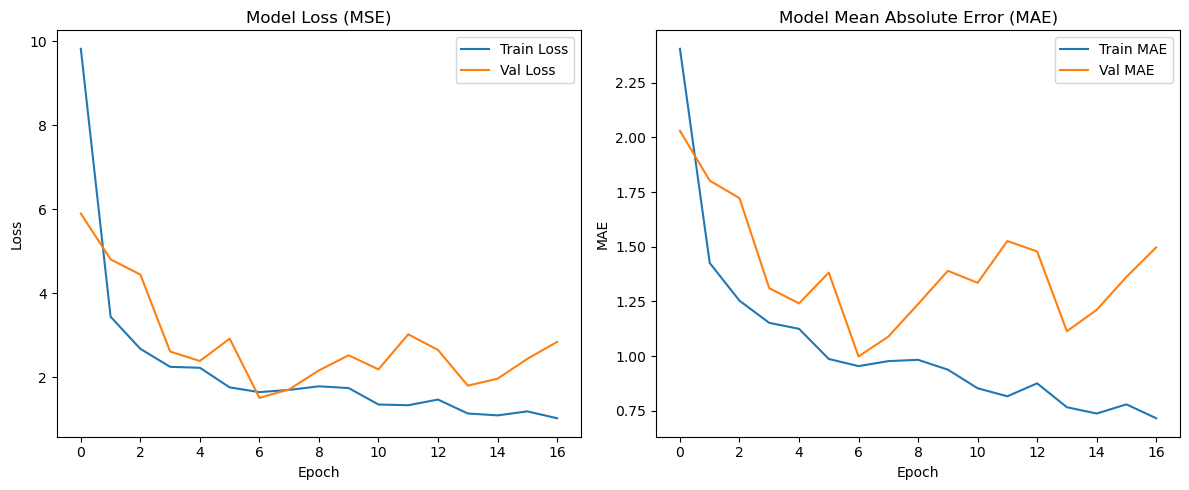

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history2.history['mae'], label='Train MAE')
plt.plot(history2.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss and MAE values after epoch 10
start_epoch = 10

plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'][start_epoch:], label='Train Loss')
plt.plot(history2.history['val_loss'][start_epoch:], label='Val Loss')
plt.title('Model Loss (MSE) — After Epoch 10')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history2.history['mae'][start_epoch:], label='Train MAE')
plt.plot(history2.history['val_mae'][start_epoch:], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE) — After Epoch 10')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate loss and MAE
test_loss, test_mae = model2.evaluate(test_ds_msk)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.xlabel("True LAI")
plt.ylabel("Predicted LAI")
plt.title("True vs Predicted LAI on Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

# Extraire images, masques et vraies valeurs (voir unbatching plus haut)
images = []
masks = []
true_lai = []

for (x, y) in test_ds_msk.unbatch().take(100):  # ou plus si tu veux
    img, mask = x
    images.append(img.numpy())
    masks.append(mask.numpy())
    true_lai.append(y.numpy())

images = np.array(images)
masks = np.array(masks)
true_lai = np.array(true_lai).flatten()

# Prédictions
pred_lai = model2.predict([images, masks]).flatten()

# Calcul du R²
r2 = r2_score(true_lai, pred_lai)
print(f"R² (R-squared): {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
R² (R-squared): 0.2883


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Model 2: couches de convolution pour mask et MobileNetV2 pour image

In [83]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, ReLU, concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Parameters ---
IMAGE_SIZE = (512, 512)
EPOCHS = 500
LR = 1e-4

# --- Backbone MobileNetV2 for images ---
image_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze pretrained weights
x = base_model(image_input, training=False)
x = GlobalAveragePooling2D()(x)

# --- Mask branch ---
mask_input = Input(shape=(*IMAGE_SIZE, 1), name='mask_input')
m = Conv2D(16, (3, 3), padding='same')(mask_input)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2, 2))(m)

m = Conv2D(32, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2, 2))(m)

m = Conv2D(64, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2, 2))(m)

m = GlobalAveragePooling2D()(m)

# --- Merge image and mask branches ---
combined = concatenate([x, m])

# --- Fully connected head ---
fc = Dense(256, activation='relu')(combined)
fc = Dropout(0.5)(fc)
fc = Dense(64, activation='relu')(fc)
output = Dense(1, activation='linear')(fc)

# --- Model ---
model3 = Model(inputs=[image_input, mask_input], outputs=output)
model3.summary()

# --- Compile ---
optimizer = Adam(learning_rate=LR)
model3.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- Training ---
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history3 = model3.fit(train_ds_msk,  # This must yield ([image, mask], label)
                    validation_data=val_ds_msk,
                    epochs=EPOCHS,
                    callbacks=[early_stop])

# --- Save model ---
model3.save('lai_transfer_mobilenetv2_maske_image.h5')


/tmp/ipykernel_1365488/2327982074.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mask_input          │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 512, 512,  │        160 │ mask_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 256, 256,  │          0 │ re_lu_9[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ re_lu_10[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 16, 16,    │  2,257,984 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ re_lu_11[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_11

 Total params: 2,642,561 (10.08 MB)

 Trainable params: 384,353 (1.47 MB)

 Non-trainable params: 2,258,208 (8.61 MB)

Epoch 1/500


2025-09-24 11:59:19.361668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 608 of 1000
2025-09-24 11:59:22.081540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 7.5751 - mae: 2.1878 - val_loss: 0.5807 - val_mae: 0.6283
Epoch 2/500


2025-09-24 12:01:32.310730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 584 of 1000
2025-09-24 12:01:35.588258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.9129 - mae: 0.7420 - val_loss: 0.3325 - val_mae: 0.4528
Epoch 3/500


2025-09-24 12:03:47.733551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 565 of 1000
2025-09-24 12:03:51.398629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.8191 - mae: 0.6992 - val_loss: 0.4026 - val_mae: 0.5038
Epoch 4/500


2025-09-24 12:06:04.181931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 576 of 1000
2025-09-24 12:06:07.659571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 0.6582 - mae: 0.6298 - val_loss: 0.3507 - val_mae: 0.4608
Epoch 5/500


2025-09-24 12:08:22.932838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 570 of 1000
2025-09-24 12:08:26.666789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 0.5317 - mae: 0.5637 - val_loss: 0.2686 - val_mae: 0.3941
Epoch 6/500


2025-09-24 12:10:43.258499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 572 of 1000
2025-09-24 12:10:46.699501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.4713 - mae: 0.5449 - val_loss: 0.2438 - val_mae: 0.3784
Epoch 7/500


2025-09-24 12:12:50.262251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 554 of 1000
2025-09-24 12:12:54.379328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.4847 - mae: 0.5333 - val_loss: 0.2601 - val_mae: 0.3987
Epoch 8/500


2025-09-24 12:14:57.434131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 550 of 1000
2025-09-24 12:15:01.620265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.4178 - mae: 0.4883 - val_loss: 0.1911 - val_mae: 0.3332
Epoch 9/500


2025-09-24 12:17:04.089585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 575 of 1000
2025-09-24 12:17:07.693779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.3643 - mae: 0.4624 - val_loss: 0.1772 - val_mae: 0.3148
Epoch 10/500


2025-09-24 12:19:10.726115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 600 of 1000
2025-09-24 12:19:13.718684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.3243 - mae: 0.4409 - val_loss: 0.1208 - val_mae: 0.2763
Epoch 11/500


2025-09-24 12:21:16.896663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 593 of 1000
2025-09-24 12:21:20.015126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.4148 - mae: 0.5037 - val_loss: 0.1087 - val_mae: 0.2541
Epoch 12/500


2025-09-24 12:23:23.108813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 593 of 1000
2025-09-24 12:23:26.206741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2907 - mae: 0.4156 - val_loss: 0.1101 - val_mae: 0.2663
Epoch 13/500


2025-09-24 12:25:28.880928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-24 12:25:32.378952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.3011 - mae: 0.4197 - val_loss: 0.1036 - val_mae: 0.2590
Epoch 14/500


2025-09-24 12:27:36.016031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 557 of 1000
2025-09-24 12:27:39.940199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2836 - mae: 0.4159 - val_loss: 0.0876 - val_mae: 0.2323
Epoch 15/500


2025-09-24 12:29:42.019627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 576 of 1000
2025-09-24 12:29:45.604263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.3062 - mae: 0.4141 - val_loss: 0.1052 - val_mae: 0.2580
Epoch 16/500


2025-09-24 12:31:48.439683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 592 of 1000
2025-09-24 12:31:51.546325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2915 - mae: 0.4139 - val_loss: 0.1387 - val_mae: 0.2962
Epoch 17/500


2025-09-24 12:33:54.342513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 568 of 1000
2025-09-24 12:33:58.076696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.2921 - mae: 0.4219 - val_loss: 0.0874 - val_mae: 0.2375
Epoch 18/500


2025-09-24 12:36:00.837911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 602 of 1000
2025-09-24 12:36:03.826326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2543 - mae: 0.3891 - val_loss: 0.1536 - val_mae: 0.3160
Epoch 19/500


2025-09-24 12:38:06.906881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 595 of 1000
2025-09-24 12:38:09.981121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2894 - mae: 0.3901 - val_loss: 0.1376 - val_mae: 0.3042
Epoch 20/500


2025-09-24 12:40:12.906713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 556 of 1000
2025-09-24 12:40:16.898649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2339 - mae: 0.3731 - val_loss: 0.0841 - val_mae: 0.2366
Epoch 21/500


2025-09-24 12:42:18.983341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 576 of 1000
2025-09-24 12:42:22.584858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2485 - mae: 0.3662 - val_loss: 0.1538 - val_mae: 0.3236
Epoch 22/500


2025-09-24 12:44:25.288991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 568 of 1000
2025-09-24 12:44:29.076600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.2453 - mae: 0.3832 - val_loss: 0.1369 - val_mae: 0.3014
Epoch 23/500


2025-09-24 12:46:32.040027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 585 of 1000
2025-09-24 12:46:35.467180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2482 - mae: 0.3670 - val_loss: 0.1137 - val_mae: 0.2702
Epoch 24/500


2025-09-24 12:48:37.870319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 593 of 1000
2025-09-24 12:48:41.098445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2083 - mae: 0.3538 - val_loss: 0.1510 - val_mae: 0.3120
Epoch 25/500


2025-09-24 12:50:43.882795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 599 of 1000
2025-09-24 12:50:46.893888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2037 - mae: 0.3473 - val_loss: 0.1158 - val_mae: 0.2715
Epoch 26/500


2025-09-24 12:52:49.615583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 572 of 1000
2025-09-24 12:52:53.328091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2095 - mae: 0.3541 - val_loss: 0.1038 - val_mae: 0.2694
Epoch 27/500


2025-09-24 12:54:56.028269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 598 of 1000
2025-09-24 12:54:59.094849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - loss: 0.2307 - mae: 0.3564 - val_loss: 0.0845 - val_mae: 0.2332
Epoch 28/500


2025-09-24 12:57:01.313022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 599 of 1000
2025-09-24 12:57:04.269917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.1730 - mae: 0.3194 - val_loss: 0.1470 - val_mae: 0.3225
Epoch 29/500


2025-09-24 12:59:06.993929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 574 of 1000
2025-09-24 12:59:10.613184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - loss: 0.1836 - mae: 0.3265 - val_loss: 0.1842 - val_mae: 0.3594
Epoch 30/500


2025-09-24 13:01:13.509795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 592 of 1000
2025-09-24 13:01:16.655676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - loss: 0.2193 - mae: 0.3422 - val_loss: 0.1529 - val_mae: 0.3309


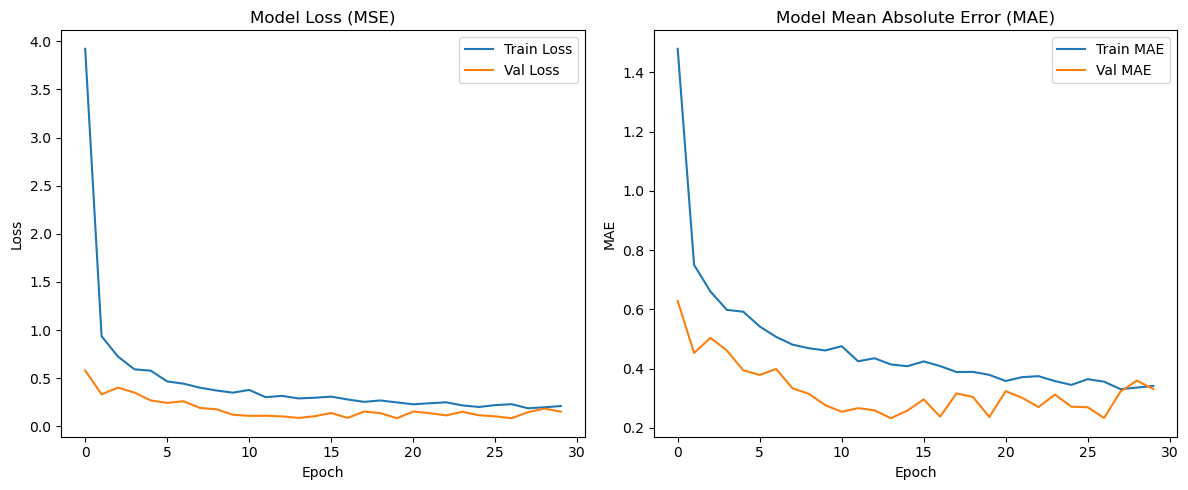

In [84]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history3.history['mae'], label='Train MAE')
plt.plot(history3.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [85]:
# Best (lowest) training MAE and loss
best_train_mae = min(history3.history['mae'])
best_train_loss = min(history3.history['loss'])

# Best (lowest) validation MAE and loss
best_val_mae = min(history3.history['val_mae'])
best_val_loss = min(history3.history['val_loss'])

print(f"Best Train MAE: {best_train_mae:.4f}")
print(f"Best Train Loss (MSE): {best_train_loss:.4f}")
print(f"Best Val MAE: {best_val_mae:.4f}")
print(f"Best Val Loss (MSE): {best_val_loss:.4f}")

Best Train MAE: 0.3305
Best Train Loss (MSE): 0.1877
Best Val MAE: 0.2323
Best Val Loss (MSE): 0.0841


In [ ]:
# Evaluate loss and MAE
test_loss, test_mae = model3.evaluate(test_ds_msk)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

In [96]:
# Unbatch the dataset to get individual samples
test_ds_msk_unbatched = test_ds_msk.unbatch()

# Number of samples to display
num_samples = 10

# Create lists to store samples
images = []
masks = []
y_true = []

# Collect N samples
for (inputs, label) in test_ds_msk_unbatched.take(num_samples):
    img, mask = inputs
    images.append(img.numpy())
    masks.append(mask.numpy())
    y_true.append(label.numpy())

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)
y_true = np.array(y_true).flatten()

# Make predictions
y_pred = model3.predict([images, masks]).flatten()
for i in range(num_samples):
  print(f"True: {y_true[i]:.2f} Pred: {y_pred[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
True: 3.96 Pred: 3.69
True: 0.78 Pred: 0.96
True: 3.86 Pred: 3.82
True: 2.36 Pred: 2.24
True: 2.59 Pred: 2.55
True: 0.66 Pred: 0.60
True: 4.82 Pred: 4.43
True: 2.84 Pred: 2.74
True: 4.65 Pred: 5.14
True: 4.98 Pred: 4.62


2025-09-25 10:04:41.757732: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


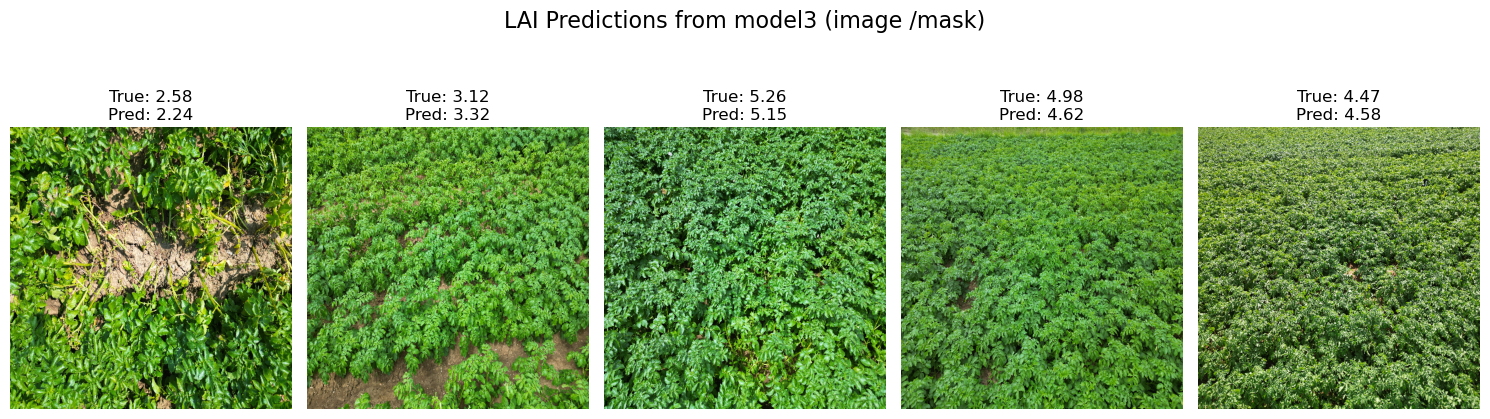

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Unbatch the dataset to get individual samples
test_ds_msk_unbatched = test_ds_msk.unbatch()

# Number of samples to display
num_samples = 5

# Create lists to store samples
images = []
masks = []
y_true = []

# Collect N samples
for (inputs, label) in test_ds_msk_unbatched.take(num_samples):
    img, mask = inputs
    images.append(img.numpy())
    masks.append(mask.numpy())
    y_true.append(label.numpy())

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)
y_true = np.array(y_true).flatten()

# Make predictions
y_pred = model3.predict([images, masks]).flatten()

# Plot results
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {y_true[i]:.2f}\nPred: {y_pred[i]:.2f}")

plt.suptitle("LAI Predictions from model3 (image /mask)", fontsize=16)
plt.tight_layout()
plt.show()


In [91]:
from sklearn.metrics import r2_score
import numpy as np

# Extraire images, masques et vraies valeurs (voir unbatching plus haut)
images = []
masks = []
true_lai = []

for (x, y) in test_ds_msk.unbatch().take(100):  # ou plus si tu veux
    img, mask = x
    images.append(img.numpy())
    masks.append(mask.numpy())
    true_lai.append(y.numpy())

images = np.array(images)
masks = np.array(masks)
true_lai = np.array(true_lai).flatten()

# Prédictions
pred_lai = model3.predict([images, masks]).flatten()

# Calcul du R²
r2 = r2_score(true_lai, pred_lai)
print(f"R² (R-squared): {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
R² (R-squared): 0.9509


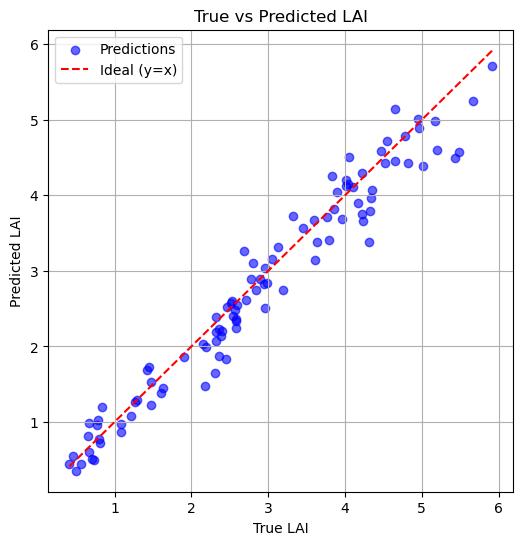

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(true_lai, pred_lai, alpha=0.6, color='blue', label='Predictions')
plt.plot([true_lai.min(), true_lai.max()],
         [true_lai.min(), true_lai.max()],
         'r--', label='Ideal (y=x)')
plt.xlabel('True LAI')
plt.ylabel('Predicted LAI')
plt.title('True vs Predicted LAI')
plt.legend()
plt.grid(True)
plt.show()


### image + mask + date -> LAI 

Data

In [100]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

# --- Parameters ---
IMAGE_SIZE = (512, 512)  
BATCH_SIZE = 16
EPOCHS = 500

# --- Paths ---
df = pd.read_csv('../Data/label.csv')     # Must contain 'img_path' and 'lai_full'
image_dir = '../Data/images'
mask_dir = '../Data/masks'

# --- Construct full image path ---
def resolve_image_path(p):
    filename = os.path.basename(str(p)).replace('\\', '/')
    return os.path.join(image_dir, filename)

# --- Derive mask path from image name ---
def resolve_mask_path(p):
    filename = os.path.basename(str(p)).replace('\\', '/').replace('.jpg', '')
    parts = filename.split('_')
    
    if len(parts) < 4:
        raise ValueError(f"Unexpected filename format: {filename}")

    # Insert "_mask_" after the first three segments
    mask_filename = '_'.join(parts[:4]) + '_mask_' + '_'.join(parts[4:]) + '.jpg'
    return os.path.join(mask_dir, mask_filename)

# --- Apply path resolution ---
df['image_path'] = df['img_path'].apply(resolve_image_path)
df['mask_path'] = df['img_path'].apply(resolve_mask_path)

image_paths = df['image_path'].values
mask_paths = df['mask_path'].values
lai_values = df['lai_full'].values.astype('float32')

# --- File existence validation ---
for path_list, label in [(image_paths, "image"), (mask_paths, "mask")]:
    missing = [p for p in path_list if not os.path.exists(p)]
    if missing:
        print(f"Missing {label} files:")
        for m in missing:
            print("  ", m)
        raise FileNotFoundError(f"Some {label} files are missing. Ensure consistency in naming convention.")

# --- Dates as numeric input ---
date_values = df['date'].values.astype('float32')
date_values = date_values / 1000.0  # simple normalisation (716 -> 0.716)

# --- Train/Test Split with date ---
train_img, test_img, train_mask, test_mask, train_lai, test_lai, train_date, test_date = train_test_split(
    image_paths, mask_paths, lai_values, date_values, test_size=0.1, random_state=42
)
train_img, val_img, train_mask, val_mask, train_lai, val_lai, train_date, val_date = train_test_split(
    train_img, train_mask, train_lai, train_date, test_size=0.2, random_state=42
)

# --- Preprocessing for image-mask-label triple ---
def preprocess(img_path, mask_path, date, label):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # grayscale
    mask = tf.image.resize(mask, IMAGE_SIZE)
    mask = mask / 255.0

    # Date is already numeric
    return (img, mask, date), label


def make_dataset(img_paths, mask_paths, dates, labels):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, dates, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Datasets ready for training ---
train_ds_msk_date = make_dataset(train_img, train_mask, train_date, train_lai)
val_ds_msk_date   = make_dataset(val_img, val_mask, val_date, val_lai)
test_ds_msk_date  = make_dataset(test_img, test_mask, test_date, test_lai)



In [101]:
print(df['date'].head(10))


0    716
1    716
2    716
3    716
4    716
5    716
6    716
7    716
8    716
9    716
Name: date, dtype: int64


Model1 : injecter la date comme entier 

In [102]:
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, concatenate, BatchNormalization
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, ReLU, concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SIZE = (512, 512)
EPOCHS = 500
LR = 1e-4
# --- Inputs ---
image_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
mask_input  = Input(shape=(*IMAGE_SIZE, 1), name='mask_input')
date_input  = Input(shape=(1,), name='date_input')  # la date en numérique

# --- Image branch ---
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False
x = base_model(image_input, training=False)
x = GlobalAveragePooling2D()(x)

# --- Mask branch ---
m = Conv2D(16, (3,3), padding='same')(mask_input)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2,2))(m)

m = Conv2D(32, (3,3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2,2))(m)

m = Conv2D(64, (3,3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2,2))(m)
m = GlobalAveragePooling2D()(m)

# --- Date branch ---
d = Dense(32, activation='relu')(date_input)

# --- Merge everything ---
combined = concatenate([x, m, d])

fc = Dense(256, activation='relu')(combined)
fc = Dropout(0.5)(fc)
fc = Dense(64, activation='relu')(fc)
output = Dense(1, activation='linear')(fc)

# --- Model ---
model_date = Model(inputs=[image_input, mask_input, date_input], outputs=output)
model_date.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
model_date.summary()


# --- Compile ---
optimizer = Adam(learning_rate=LR)
model_date.compile(optimizer=optimizer, loss='mse', metrics=['mae'])




/tmp/ipykernel_1365488/4091602085.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mask_input          │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 512, 512,  │        160 │ mask_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 256, 256,  │          0 │ re_lu_15[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_15… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ re_lu_16[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 16, 16,    │  2,257,984 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ date_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00

 Total params: 2,650,817 (10.11 MB)

 Trainable params: 392,609 (1.50 MB)

 Non-trainable params: 2,258,208 (8.61 MB)

In [103]:
# --- Training ---
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history4 = model_date.fit(train_ds_msk_date,  # This must yield ([image, mask], label)
                    validation_data=val_ds_msk_date,
                    epochs=EPOCHS,
                    callbacks=[early_stop])

# --- Save model ---
model_date.save('lai_transfer_mobilenetv2_maske_image_date.h5')

Epoch 1/500


2025-09-25 10:22:44.042081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 10:22:47.283063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 2.8402 - mae: 1.3127 - val_loss: 0.4002 - val_mae: 0.5079
Epoch 2/500


2025-09-25 10:25:00.799397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 589 of 1000
2025-09-25 10:25:04.032452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.7779 - mae: 0.6837 - val_loss: 0.3088 - val_mae: 0.4481
Epoch 3/500


2025-09-25 10:27:16.027561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 10:27:19.378651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.4788 - mae: 0.5511 - val_loss: 0.2665 - val_mae: 0.4070
Epoch 4/500


2025-09-25 10:29:29.239442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 585 of 1000
2025-09-25 10:29:32.524307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.4812 - mae: 0.5249 - val_loss: 0.2752 - val_mae: 0.4103
Epoch 5/500


2025-09-25 10:31:41.978026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 10:31:45.363065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.3801 - mae: 0.4751 - val_loss: 0.2026 - val_mae: 0.3538
Epoch 6/500


2025-09-25 10:33:56.967413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 566 of 1000
2025-09-25 10:34:00.698995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.3340 - mae: 0.4384 - val_loss: 0.1717 - val_mae: 0.3217
Epoch 7/500


2025-09-25 10:36:11.412081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 582 of 1000
2025-09-25 10:36:14.816539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.2874 - mae: 0.4271 - val_loss: 0.1355 - val_mae: 0.2857
Epoch 8/500


2025-09-25 10:38:25.217685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 588 of 1000
2025-09-25 10:38:28.522187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.2703 - mae: 0.4028 - val_loss: 0.1216 - val_mae: 0.2709
Epoch 9/500


2025-09-25 10:40:38.960414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 10:40:42.369431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.3258 - mae: 0.4359 - val_loss: 0.1269 - val_mae: 0.2788
Epoch 10/500


2025-09-25 10:42:53.093912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 591 of 1000
2025-09-25 10:42:56.306207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2965 - mae: 0.4156 - val_loss: 0.1131 - val_mae: 0.2632
Epoch 11/500


2025-09-25 10:45:08.185398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 583 of 1000
2025-09-25 10:45:11.628623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.2584 - mae: 0.3858 - val_loss: 0.1919 - val_mae: 0.3581
Epoch 12/500


2025-09-25 10:47:22.190807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 547 of 1000
2025-09-25 10:47:26.524958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - loss: 0.2579 - mae: 0.3848 - val_loss: 0.1588 - val_mae: 0.3186
Epoch 13/500


2025-09-25 10:49:37.797497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 10:49:41.170724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2551 - mae: 0.3877 - val_loss: 0.2098 - val_mae: 0.3861
Epoch 14/500


2025-09-25 10:51:52.733123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 565 of 1000
2025-09-25 10:51:56.362253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2296 - mae: 0.3744 - val_loss: 0.2123 - val_mae: 0.3868
Epoch 15/500


2025-09-25 10:54:07.894705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 587 of 1000
2025-09-25 10:54:11.176689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2290 - mae: 0.3728 - val_loss: 0.1549 - val_mae: 0.3230
Epoch 16/500


2025-09-25 10:56:22.830235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 584 of 1000
2025-09-25 10:56:26.180064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2321 - mae: 0.3628 - val_loss: 0.1951 - val_mae: 0.3730
Epoch 17/500


2025-09-25 10:58:37.741731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 574 of 1000
2025-09-25 10:58:41.229337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2136 - mae: 0.3550 - val_loss: 0.2228 - val_mae: 0.3980
Epoch 18/500


2025-09-25 11:00:52.529463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 587 of 1000
2025-09-25 11:00:55.848875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2020 - mae: 0.3458 - val_loss: 0.2709 - val_mae: 0.4518
Epoch 19/500


2025-09-25 11:03:07.159134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 586 of 1000
2025-09-25 11:03:10.525458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - loss: 0.1930 - mae: 0.3225 - val_loss: 0.2019 - val_mae: 0.3847
Epoch 20/500


2025-09-25 11:05:22.659728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:353: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 11:05:26.031209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2107 - mae: 0.3439 - val_loss: 0.2958 - val_mae: 0.4779


In [104]:
# Evaluate loss and MAE
test_loss, test_mae = model_date.evaluate(test_ds_msk_date)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 915ms/step - loss: 0.1326 - mae: 0.2782
Test Loss (MSE): 0.1435
Test MAE: 0.2902


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Data

In [105]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

# --- Parameters ---
IMAGE_SIZE = (512, 512)  
BATCH_SIZE = 16
EPOCHS = 500

# --- Paths ---
df = pd.read_csv('../Data/label.csv')     # Must contain 'img_path', 'lai_full', 'date'
image_dir = '../Data/images'
mask_dir = '../Data/masks'

# --- Construct full image path ---
def resolve_image_path(p):
    filename = os.path.basename(str(p)).replace('\\', '/')
    return os.path.join(image_dir, filename)

# --- Derive mask path from image name ---
def resolve_mask_path(p):
    filename = os.path.basename(str(p)).replace('\\', '/').replace('.jpg', '')
    parts = filename.split('_')
    
    if len(parts) < 4:
        raise ValueError(f"Unexpected filename format: {filename}")

    mask_filename = '_'.join(parts[:4]) + '_mask_' + '_'.join(parts[4:]) + '.jpg'
    return os.path.join(mask_dir, mask_filename)

# --- Apply path resolution ---
df['image_path'] = df['img_path'].apply(resolve_image_path)
df['mask_path'] = df['img_path'].apply(resolve_mask_path)

image_paths = df['image_path'].values
mask_paths = df['mask_path'].values
lai_values = df['lai_full'].values.astype('float32')

# --- File existence validation ---
for path_list, label in [(image_paths, "image"), (mask_paths, "mask")]:
    missing = [p for p in path_list if not os.path.exists(p)]
    if missing:
        print(f"Missing {label} files:")
        for m in missing:
            print("  ", m)
        raise FileNotFoundError(f"Some {label} files are missing. Ensure consistency in naming convention.")

# --- Convert date (716 -> July 16) ---
df['month'] = (df['date'] // 100).astype(int)
df['day'] = (df['date'] % 100).astype(int)

# --- Cyclic encoding of month/day ---
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31.0)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31.0)

# Combine into a single array for each row
date_features = df[['month_sin', 'month_cos', 'day_sin', 'day_cos']].values.astype('float32')

# --- Train/Test Split with date features ---
train_img, test_img, train_mask, test_mask, train_lai, test_lai, train_date, test_date = train_test_split(
    image_paths, mask_paths, lai_values, date_features, test_size=0.1, random_state=42
)
train_img, val_img, train_mask, val_mask, train_lai, val_lai, train_date, val_date = train_test_split(
    train_img, train_mask, train_lai, train_date, test_size=0.2, random_state=42
)

# --- Preprocessing for image-mask-date-label triple ---
def preprocess(img_path, mask_path, date, label):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMAGE_SIZE)
    mask = mask / 255.0

    # Date must be shaped (1,) for Dense input
    date = tf.reshape(date, (4,))  # (1,) per sample

    # Return ([img, mask, date], label) instead of (img, mask, date, label)
    return (img, mask, date), label


def make_dataset(img_paths, mask_paths, dates, labels):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, dates, labels))
    ds = ds.map(lambda img, mask, date, label: preprocess(img, mask, date, label),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Datasets ready for training ---
train_ds_msk_date2 = make_dataset(train_img, train_mask, train_date, train_lai)
val_ds_msk_date2   = make_dataset(val_img, val_mask, val_date, val_lai)
test_ds_msk_dat2  = make_dataset(test_img, test_mask, test_date, test_lai)

print("Example encoded date features for first sample:")
print(train_date[0])  # Should show 4 numbers [month_sin, month_cos, day_sin, day_cos]


Example encoded date features for first sample:
[-0.8660254  -0.5         0.48530197 -0.8743466 ]


Model2 : injecter la date encoder

In [107]:
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, concatenate, BatchNormalization
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, ReLU, concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SIZE = (512, 512)
EPOCHS = 500
LR = 1e-4
# --- Inputs ---
image_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
mask_input  = Input(shape=(*IMAGE_SIZE, 1), name='mask_input')
date_input  = Input(shape=(4,), name='date_input')  # la date en numérique

# --- Image branch ---
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False
x = base_model(image_input, training=False)
x = GlobalAveragePooling2D()(x)

# --- Mask branch ---
m = Conv2D(16, (3,3), padding='same')(mask_input)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2,2))(m)

m = Conv2D(32, (3,3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2,2))(m)

m = Conv2D(64, (3,3), padding='same')(m)
m = BatchNormalization()(m)
m = ReLU()(m)
m = MaxPooling2D((2,2))(m)
m = GlobalAveragePooling2D()(m)

# --- Date branch ---
d = Dense(32, activation='relu')(date_input)

# --- Merge everything ---
combined = concatenate([x, m, d])

fc = Dense(256, activation='relu')(combined)
fc = Dropout(0.5)(fc)
fc = Dense(64, activation='relu')(fc)
output = Dense(1, activation='linear')(fc)

# --- Model ---
model_date2 = Model(inputs=[image_input, mask_input, date_input], outputs=output)
model_date2.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
model_date2.summary()


# --- Compile ---
optimizer = Adam(learning_rate=LR)
model_date2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])




/tmp/ipykernel_1365488/1559814384.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3),


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mask_input          │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 512, 512,  │        160 │ mask_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 256, 256,  │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 128, 128,  │          0 │ re_lu_22[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 16, 16,    │  2,257,984 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 64, 64,    │          0 │ re_lu_23[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ date_input          │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00

 Total params: 2,650,913 (10.11 MB)

 Trainable params: 392,705 (1.50 MB)

 Non-trainable params: 2,258,208 (8.61 MB)

In [108]:
# --- Training ---
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history4 = model_date2.fit(train_ds_msk_date2,  # This must yield ([image, mask], label)
                    validation_data=val_ds_msk_date2,
                    epochs=EPOCHS,
                    callbacks=[early_stop])

# --- Save model ---
model_date2.save('lai_transfer_mobilenetv2_maske_image_date_encoded.h5')

Epoch 1/500


2025-09-25 11:17:24.447724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 612 of 1000
2025-09-25 11:17:27.153133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 3.2243 - mae: 1.3617 - val_loss: 0.3124 - val_mae: 0.4283
Epoch 2/500


2025-09-25 11:19:42.479770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 565 of 1000
2025-09-25 11:19:46.207267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.5842 - mae: 0.6005 - val_loss: 0.2467 - val_mae: 0.3838
Epoch 3/500


2025-09-25 11:22:00.244477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 584 of 1000
2025-09-25 11:22:03.630389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.4920 - mae: 0.5547 - val_loss: 0.2449 - val_mae: 0.3807
Epoch 4/500


2025-09-25 11:24:16.066071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 575 of 1000
2025-09-25 11:24:19.485741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.4757 - mae: 0.5251 - val_loss: 0.1938 - val_mae: 0.3378
Epoch 5/500


2025-09-25 11:26:30.435242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 586 of 1000
2025-09-25 11:26:33.779020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.3714 - mae: 0.4721 - val_loss: 0.1738 - val_mae: 0.3162
Epoch 6/500


2025-09-25 11:28:43.974526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 534 of 1000
2025-09-25 11:28:48.679485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.3384 - mae: 0.4568 - val_loss: 0.1979 - val_mae: 0.3323
Epoch 7/500


2025-09-25 11:30:59.370585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 585 of 1000
2025-09-25 11:31:02.691965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.3160 - mae: 0.4438 - val_loss: 0.1475 - val_mae: 0.2820
Epoch 8/500


2025-09-25 11:33:14.397646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 565 of 1000
2025-09-25 11:33:18.160520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.3218 - mae: 0.4400 - val_loss: 0.1191 - val_mae: 0.2727
Epoch 9/500


2025-09-25 11:35:27.443185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 589 of 1000
2025-09-25 11:35:30.697136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.2658 - mae: 0.3992 - val_loss: 0.1208 - val_mae: 0.2766
Epoch 10/500


2025-09-25 11:37:40.231674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 592 of 1000
2025-09-25 11:37:43.514065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2824 - mae: 0.4100 - val_loss: 0.1183 - val_mae: 0.2691
Epoch 11/500


2025-09-25 11:39:55.142696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 587 of 1000
2025-09-25 11:39:58.525086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.3064 - mae: 0.4360 - val_loss: 0.1343 - val_mae: 0.3024
Epoch 12/500


2025-09-25 11:42:10.767180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 570 of 1000
2025-09-25 11:42:14.372690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.2400 - mae: 0.3808 - val_loss: 0.2518 - val_mae: 0.4391
Epoch 13/500


2025-09-25 11:44:26.988964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 595 of 1000
2025-09-25 11:44:30.131878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.2362 - mae: 0.3785 - val_loss: 0.1616 - val_mae: 0.3437
Epoch 14/500


2025-09-25 11:46:42.248280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 564 of 1000
2025-09-25 11:46:46.025531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.2232 - mae: 0.3584 - val_loss: 0.1781 - val_mae: 0.3625
Epoch 15/500


2025-09-25 11:48:59.826985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 588 of 1000
2025-09-25 11:49:03.113574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - loss: 0.2343 - mae: 0.3566 - val_loss: 0.1482 - val_mae: 0.3263
Epoch 16/500


2025-09-25 11:51:16.446040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 584 of 1000
2025-09-25 11:51:19.815553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.2159 - mae: 0.3625 - val_loss: 0.1076 - val_mae: 0.2700
Epoch 17/500


2025-09-25 11:53:32.960854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 578 of 1000
2025-09-25 11:53:36.426727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.1970 - mae: 0.3387 - val_loss: 0.2536 - val_mae: 0.4423
Epoch 18/500


2025-09-25 11:55:48.178123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 589 of 1000
2025-09-25 11:55:51.487063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.1997 - mae: 0.3346 - val_loss: 0.3327 - val_mae: 0.5139
Epoch 19/500


2025-09-25 11:58:03.890743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 584 of 1000
2025-09-25 11:58:07.277487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.1935 - mae: 0.3360 - val_loss: 0.1203 - val_mae: 0.2877
Epoch 20/500


2025-09-25 12:00:18.878850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 581 of 1000
2025-09-25 12:00:22.233179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.1948 - mae: 0.3469 - val_loss: 0.1879 - val_mae: 0.3744
Epoch 21/500


2025-09-25 12:02:34.174691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 585 of 1000
2025-09-25 12:02:37.496845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.2244 - mae: 0.3616 - val_loss: 0.2552 - val_mae: 0.4376
Epoch 22/500


2025-09-25 12:04:47.420612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 554 of 1000
2025-09-25 12:04:51.508147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.1910 - mae: 0.3290 - val_loss: 0.1969 - val_mae: 0.3823
Epoch 23/500


2025-09-25 12:07:01.716504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 588 of 1000
2025-09-25 12:07:05.007240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 0.1963 - mae: 0.3366 - val_loss: 0.2776 - val_mae: 0.4663
Epoch 24/500


2025-09-25 12:09:10.958838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 589 of 1000
2025-09-25 12:09:14.147903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 0.1719 - mae: 0.3177 - val_loss: 0.1506 - val_mae: 0.3322
Epoch 25/500


2025-09-25 12:11:20.261038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 594 of 1000
2025-09-25 12:11:23.409342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 0.1765 - mae: 0.3177 - val_loss: 0.1975 - val_mae: 0.3856
Epoch 26/500


2025-09-25 12:13:29.329150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:371: Filling up shuffle buffer (this may take a while): 598 of 1000
2025-09-25 12:13:32.351216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 0.1704 - mae: 0.3135 - val_loss: 0.2727 - val_mae: 0.4502


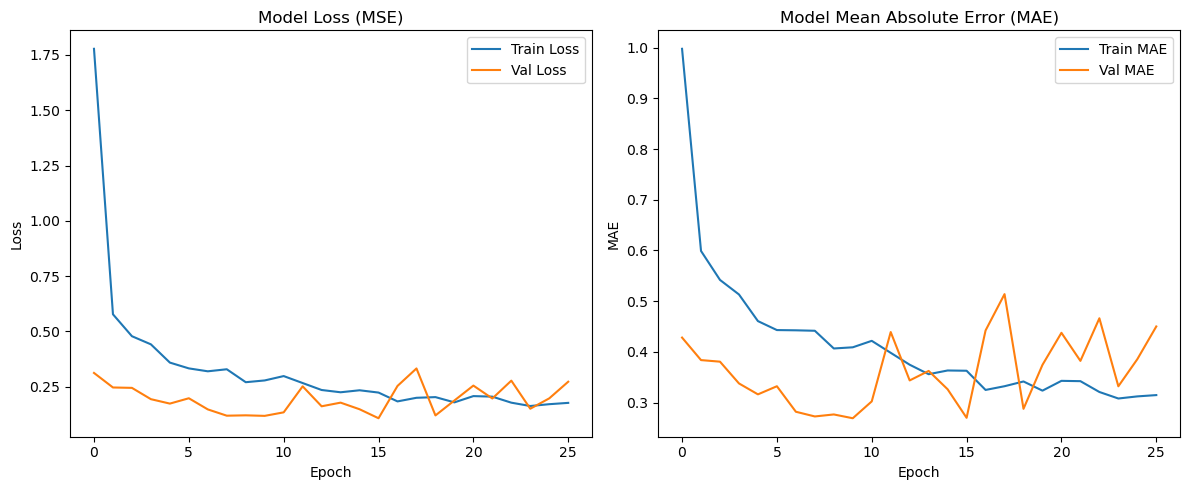

In [109]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot MAE ---
plt.subplot(1, 2, 2)
plt.plot(history4.history['mae'], label='Train MAE')
plt.plot(history4.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [111]:
# Best (lowest) training MAE and loss
best_train_mae = min(history4.history['mae'])
best_train_loss = min(history4.history['loss'])

# Best (lowest) validation MAE and loss
best_val_mae = min(history4.history['val_mae'])
best_val_loss = min(history4.history['val_loss'])

print(f"Best Train MAE: {best_train_mae:.4f}")
print(f"Best Train Loss (MSE): {best_train_loss:.4f}")
print(f"Best Val MAE: {best_val_mae:.4f}")
print(f"Best Val Loss (MSE): {best_val_loss:.4f}")

Best Train MAE: 0.3081
Best Train Loss (MSE): 0.1629
Best Val MAE: 0.2691
Best Val Loss (MSE): 0.1076


In [114]:
# Evaluate loss and MAE
test_loss, test_mae = model_date2.evaluate(test_ds_msk_dat2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 933ms/step - loss: 0.1273 - mae: 0.2744
Test Loss (MSE): 0.1328
Test MAE: 0.2843


In [115]:
from sklearn.metrics import r2_score
import numpy as np
import tensorflow as tf

# --- Extraire images, masques, dates et vraies valeurs ---
images = []
masks = []
dates = []
true_lai = []

for (x, y) in test_ds_msk_dat2.unbatch().take(100):  
    img, mask, date = x  # dataset retourne ((img, mask, date), label)
    images.append(img.numpy().astype(np.float32))
    masks.append(mask.numpy().astype(np.float32))
    dates.append(date.numpy().astype(np.float32))
    true_lai.append(y.numpy().astype(np.float32))

# --- Conversion en numpy arrays ---
images = np.array(images)
masks = np.array(masks)
dates = np.array(dates)  # ⬅️ ne pas reshape si c’est déjà (N,4)
true_lai = np.array(true_lai).flatten()

# Assurer la forme correcte pour les masques
if masks.ndim == 3:  
    masks = np.expand_dims(masks, -1)

# --- Prédictions ---
pred_lai = model_date2.predict([images, masks, dates], verbose=0).flatten()

# --- Calcul du R² ---
r2 = r2_score(true_lai, pred_lai)
print(f"R² (R-squared): {r2:.4f}")


R² (R-squared): 0.9415


### amélioration du 3ème modèle

Index(['img_path', 'zone', 'angle', 'orientation', 'num_img',
       'gap_probability', 'lai_full', 'gap_probability_10', 'lai_10', 'date'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

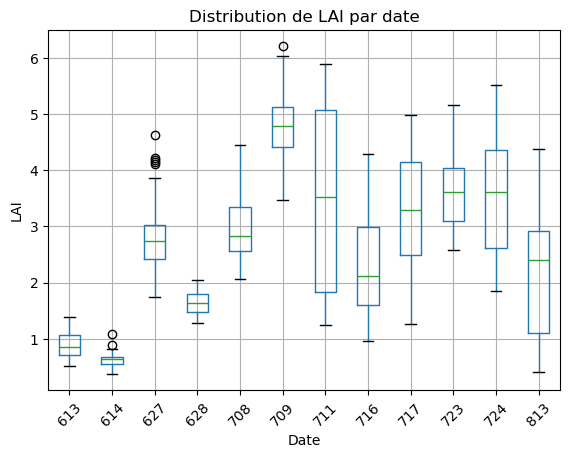

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Charger ton CSV ---
df = pd.read_csv('../Data/label.csv')  # Remplace par ton chemin CSV

# Vérifier les colonnes
print(df.columns)

# --- On suppose que tu as 'date' et 'lai_full' ---
# Si la colonne date est en format 716, 817 etc.
df['date'] = df['date'].astype(str)

# --- Distribution par date ---
plt.figure(figsize=(10,6))
df.boxplot(column='lai_full', by='date')  # boîte à moustaches
plt.title("Distribution de LAI par date")
plt.suptitle("")  # enlève le titre automatique
plt.xlabel("Date")
plt.ylabel("LAI")
plt.xticks(rotation=45)
plt.show()




Epoch 1/100


2025-09-17 09:38:10.848318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 641 of 1000
2025-09-17 09:38:12.865322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - loss: 1175.0226 - mae: 20.2336 - val_loss: 9.4697 - val_mae: 2.7562
Epoch 2/100


2025-09-17 09:44:17.302545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 612 of 1000
2025-09-17 09:44:20.022431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - loss: 21.7448 - mae: 3.1125 - val_loss: 9.5058 - val_mae: 2.7574
Epoch 3/100


2025-09-17 09:50:24.504767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 621 of 1000
2025-09-17 09:50:27.035520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - loss: 9.2962 - mae: 2.1733 - val_loss: 9.5220 - val_mae: 2.7566
Epoch 4/100


2025-09-17 09:56:36.357000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 588 of 1000
2025-09-17 09:56:39.625890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 378s 7s/step - loss: 9.1307 - mae: 2.0717 - val_loss: 9.3470 - val_mae: 2.7240
Epoch 5/100


2025-09-17 10:02:54.309252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 591 of 1000
2025-09-17 10:02:57.461093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 375s 7s/step - loss: 8.0662 - mae: 1.9635 - val_loss: 9.1742 - val_mae: 2.6963
Epoch 6/100


2025-09-17 10:09:09.275558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 611 of 1000
2025-09-17 10:09:12.139025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - loss: 6.5514 - mae: 1.8279 - val_loss: 9.0234 - val_mae: 2.6703
Epoch 7/100


2025-09-17 10:15:18.057533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 641 of 1000
2025-09-17 10:15:20.234339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - loss: 8.9076 - mae: 2.0017 - val_loss: 8.7862 - val_mae: 2.6319
Epoch 8/100


2025-09-17 10:21:20.929574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 613 of 1000
2025-09-17 10:21:23.644795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 5.2987 - mae: 1.6331 - val_loss: 8.2459 - val_mae: 2.5394
Epoch 9/100


2025-09-17 10:27:20.157439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 618 of 1000
2025-09-17 10:27:22.776553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 364s 7s/step - loss: 6.1892 - mae: 1.6742 - val_loss: 7.7896 - val_mae: 2.4597
Epoch 10/100


2025-09-17 10:33:24.115708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 645 of 1000
2025-09-17 10:33:26.226085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - loss: 4.4911 - mae: 1.5241 - val_loss: 7.4743 - val_mae: 2.3997
Epoch 11/100


2025-09-17 10:39:27.190526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 619 of 1000
2025-09-17 10:39:29.838024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - loss: 6.5144 - mae: 1.6962 - val_loss: 7.2237 - val_mae: 2.3451
Epoch 12/100


2025-09-17 10:45:30.464359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 630 of 1000
2025-09-17 10:45:32.759372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 5.2474 - mae: 1.6018 - val_loss: 6.4727 - val_mae: 2.2108
Epoch 13/100


2025-09-17 10:51:31.211871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 10:51:33.041992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 352s 7s/step - loss: 3.7734 - mae: 1.3978 - val_loss: 5.6804 - val_mae: 2.0869
Epoch 14/100


2025-09-17 10:57:23.394402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 627 of 1000
2025-09-17 10:57:25.727425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 3.6603 - mae: 1.3029 - val_loss: 4.4964 - val_mae: 1.8335
Epoch 15/100


2025-09-17 11:03:22.030567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 609 of 1000
2025-09-17 11:03:24.857459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 3.7945 - mae: 1.4135 - val_loss: 4.0465 - val_mae: 1.7325
Epoch 16/100


2025-09-17 11:09:20.712474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 645 of 1000
2025-09-17 11:09:22.790148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 358s 7s/step - loss: 4.5921 - mae: 1.4606 - val_loss: 5.1216 - val_mae: 1.9449
Epoch 17/100


2025-09-17 11:15:18.561010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 637 of 1000
2025-09-17 11:15:20.841202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 3.4675 - mae: 1.2540 - val_loss: 4.5038 - val_mae: 1.8163
Epoch 18/100


2025-09-17 11:21:18.280434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 599 of 1000
2025-09-17 11:21:21.310391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 5.0560 - mae: 1.4743 - val_loss: 3.5083 - val_mae: 1.5708
Epoch 19/100


2025-09-17 11:27:17.926251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 591 of 1000
2025-09-17 11:27:21.140463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 2.6510 - mae: 1.1718 - val_loss: 5.1802 - val_mae: 1.9745
Epoch 20/100


2025-09-17 11:33:18.649080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 639 of 1000
2025-09-17 11:33:20.839115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 2.2485 - mae: 1.1345 - val_loss: 3.7529 - val_mae: 1.6450
Epoch 21/100


2025-09-17 11:39:18.148282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 612 of 1000
2025-09-17 11:39:20.891882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 362s 7s/step - loss: 2.0202 - mae: 1.0716 - val_loss: 4.7555 - val_mae: 1.8553
Epoch 22/100


2025-09-17 11:45:19.620160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 611 of 1000
2025-09-17 11:45:22.390262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 2.9018 - mae: 1.2412 - val_loss: 4.3753 - val_mae: 1.7941
Epoch 23/100


2025-09-17 11:51:19.293990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 600 of 1000
2025-09-17 11:51:22.296612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 2.4051 - mae: 1.0913 - val_loss: 6.1366 - val_mae: 2.1638
Epoch 24/100


2025-09-17 11:57:18.899144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 636 of 1000
2025-09-17 11:57:21.268480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 2.2316 - mae: 1.0647 - val_loss: 5.3369 - val_mae: 1.9938
Epoch 25/100


2025-09-17 12:03:18.139665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 610 of 1000
2025-09-17 12:03:20.952941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 2.4258 - mae: 1.1020 - val_loss: 4.8701 - val_mae: 1.9000
Epoch 26/100


2025-09-17 12:09:18.263405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 622 of 1000
2025-09-17 12:09:20.830800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 1.5758 - mae: 0.9186 - val_loss: 4.8936 - val_mae: 1.8599
Epoch 27/100


2025-09-17 12:15:18.828607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 652 of 1000
2025-09-17 12:15:20.777330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 2.1537 - mae: 1.0598 - val_loss: 5.8871 - val_mae: 2.1044
Epoch 28/100


2025-09-17 12:21:18.143516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 618 of 1000
2025-09-17 12:21:20.845380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 1.4280 - mae: 0.8696 - val_loss: 4.5790 - val_mae: 1.8316
Epoch 29/100


2025-09-17 12:27:18.681385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 615 of 1000
2025-09-17 12:27:21.427543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 1.4479 - mae: 0.8868 - val_loss: 5.2364 - val_mae: 1.9489
Epoch 30/100


2025-09-17 12:33:18.181503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 592 of 1000
2025-09-17 12:33:21.327048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - loss: 1.8632 - mae: 0.9556 - val_loss: 2.3846 - val_mae: 1.2872
Epoch 31/100


2025-09-17 12:39:18.108289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 634 of 1000
2025-09-17 12:39:20.431419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - loss: 1.3659 - mae: 0.8758 - val_loss: 6.3921 - val_mae: 2.1845
Epoch 32/100


2025-09-17 12:45:12.928267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 648 of 1000
2025-09-17 12:45:14.934749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 1.3491 - mae: 0.8420 - val_loss: 5.8030 - val_mae: 2.0336
Epoch 33/100


2025-09-17 12:50:59.532789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 12:51:01.358176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - loss: 1.5182 - mae: 0.9017 - val_loss: 3.8895 - val_mae: 1.6462
Epoch 34/100


2025-09-17 12:56:44.656704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 12:56:46.431551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - loss: 1.5360 - mae: 0.9394 - val_loss: 3.7599 - val_mae: 1.6357
Epoch 35/100


2025-09-17 13:02:29.723606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 13:02:31.571438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - loss: 1.5275 - mae: 0.8914 - val_loss: 5.9915 - val_mae: 2.1212
Epoch 36/100


2025-09-17 13:08:13.978130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 659 of 1000
2025-09-17 13:08:15.816624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - loss: 0.9746 - mae: 0.7320 - val_loss: 4.1385 - val_mae: 1.7201
Epoch 37/100


2025-09-17 13:13:59.238853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 618 of 1000
2025-09-17 13:14:01.826183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - loss: 1.2971 - mae: 0.8423 - val_loss: 3.5163 - val_mae: 1.5650
Epoch 38/100


2025-09-17 13:19:45.557743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 670 of 1000
2025-09-17 13:19:47.235621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - loss: 1.3640 - mae: 0.8809 - val_loss: 4.6217 - val_mae: 1.8421
Epoch 39/100


2025-09-17 13:25:30.125430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 616 of 1000
2025-09-17 13:25:32.870688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - loss: 1.2816 - mae: 0.8219 - val_loss: 5.5369 - val_mae: 2.0137
Epoch 40/100


2025-09-17 13:31:15.181451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 666 of 1000
2025-09-17 13:31:16.928454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - loss: 1.3597 - mae: 0.8549 - val_loss: 4.7068 - val_mae: 1.8794
Epoch 41/100


2025-09-17 13:36:59.182599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 641 of 1000
2025-09-17 13:37:01.307486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 353s 7s/step - loss: 0.8947 - mae: 0.7165 - val_loss: 3.1767 - val_mae: 1.5062
Epoch 42/100


2025-09-17 13:42:52.121315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 638 of 1000
2025-09-17 13:42:54.297027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 350s 7s/step - loss: 1.0209 - mae: 0.7322 - val_loss: 3.7316 - val_mae: 1.6656
Epoch 43/100


2025-09-17 13:48:42.582556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 646 of 1000
2025-09-17 13:48:44.663518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 350s 7s/step - loss: 0.8915 - mae: 0.7077 - val_loss: 2.3014 - val_mae: 1.2688
Epoch 44/100


2025-09-17 13:54:33.101838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 655 of 1000
2025-09-17 13:54:34.993604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 352s 7s/step - loss: 0.9650 - mae: 0.7289 - val_loss: 4.6606 - val_mae: 1.8762
Epoch 45/100


2025-09-17 14:00:24.705011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 659 of 1000
2025-09-17 14:00:26.605366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 350s 7s/step - loss: 0.8866 - mae: 0.7065 - val_loss: 4.5769 - val_mae: 1.8856
Epoch 46/100


2025-09-17 14:06:14.408086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 14:06:16.301027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - loss: 1.1351 - mae: 0.7905 - val_loss: 3.5716 - val_mae: 1.6533
Epoch 47/100


2025-09-17 14:12:09.336026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 648 of 1000
2025-09-17 14:12:11.360406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - loss: 0.7183 - mae: 0.6612 - val_loss: 4.0259 - val_mae: 1.7711
Epoch 48/100


2025-09-17 14:18:03.881030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 568 of 1000
2025-09-17 14:18:07.600411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - loss: 0.7165 - mae: 0.6230 - val_loss: 3.6386 - val_mae: 1.6636
Epoch 49/100


2025-09-17 14:23:58.853294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 14:24:00.734824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - loss: 0.7900 - mae: 0.6668 - val_loss: 3.6639 - val_mae: 1.6922
Epoch 50/100


2025-09-17 14:29:55.817829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 621 of 1000
2025-09-17 14:29:58.343001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - loss: 0.7536 - mae: 0.6474 - val_loss: 3.3047 - val_mae: 1.5724
Epoch 51/100


2025-09-17 14:35:50.038860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 633 of 1000
2025-09-17 14:35:52.265693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 353s 7s/step - loss: 0.6270 - mae: 0.5957 - val_loss: 2.6085 - val_mae: 1.3650
Epoch 52/100


2025-09-17 14:41:43.238271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 630 of 1000
2025-09-17 14:41:45.600564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 0.7484 - mae: 0.6676 - val_loss: 3.3931 - val_mae: 1.5845
Epoch 53/100


2025-09-17 14:47:42.319890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 638 of 1000
2025-09-17 14:47:44.553879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - loss: 0.9155 - mae: 0.7445 - val_loss: 3.8617 - val_mae: 1.7355
Epoch 54/100


2025-09-17 14:53:45.754326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 621 of 1000
2025-09-17 14:53:48.387336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - loss: 0.6191 - mae: 0.5948 - val_loss: 4.3407 - val_mae: 1.8267
Epoch 55/100


2025-09-17 14:59:51.418534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 589 of 1000
2025-09-17 14:59:54.682793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 356s 7s/step - loss: 0.7227 - mae: 0.6479 - val_loss: 3.8144 - val_mae: 1.7106
Epoch 56/100


2025-09-17 15:05:47.272645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 616 of 1000
2025-09-17 15:05:49.934981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 365s 7s/step - loss: 0.7535 - mae: 0.6167 - val_loss: 6.3671 - val_mae: 2.2641
Epoch 57/100


2025-09-17 15:11:52.184256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 598 of 1000
2025-09-17 15:11:55.240461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 365s 7s/step - loss: 0.6740 - mae: 0.6149 - val_loss: 2.7798 - val_mae: 1.4377
Epoch 58/100


2025-09-17 15:17:56.794017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 637 of 1000
2025-09-17 15:17:59.118909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - loss: 0.6729 - mae: 0.6048 - val_loss: 3.1463 - val_mae: 1.5028
Epoch 59/100


2025-09-17 15:23:53.563031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 612 of 1000
2025-09-17 15:23:56.452572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 0.4899 - mae: 0.5109 - val_loss: 2.7092 - val_mae: 1.4097
Epoch 60/100


2025-09-17 15:29:54.848453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 646 of 1000
2025-09-17 15:29:56.954847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 358s 7s/step - loss: 0.5088 - mae: 0.5317 - val_loss: 3.9255 - val_mae: 1.7309
Epoch 61/100


2025-09-17 15:35:52.452174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 618 of 1000
2025-09-17 15:35:55.168259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - loss: 0.6495 - mae: 0.5982 - val_loss: 3.4730 - val_mae: 1.6173
Epoch 62/100


2025-09-17 15:41:51.306369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 648 of 1000
2025-09-17 15:41:53.356048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - loss: 0.4959 - mae: 0.5232 - val_loss: 2.2740 - val_mae: 1.2732
Epoch 63/100


2025-09-17 15:47:48.432006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 621 of 1000
2025-09-17 15:47:51.030464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 0.5422 - mae: 0.5458 - val_loss: 2.2355 - val_mae: 1.2685
Epoch 64/100


2025-09-17 15:53:49.693079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 636 of 1000
2025-09-17 15:53:51.919259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - loss: 0.5113 - mae: 0.5233 - val_loss: 1.0526 - val_mae: 0.8413
Epoch 65/100


2025-09-17 15:59:52.842594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 640 of 1000
2025-09-17 15:59:55.039662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 354s 7s/step - loss: 0.4458 - mae: 0.4969 - val_loss: 3.1908 - val_mae: 1.5640
Epoch 66/100


2025-09-17 16:05:46.507718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 16:05:48.343045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.4009 - mae: 0.4731 - val_loss: 2.7232 - val_mae: 1.4361
Epoch 67/100


2025-09-17 16:11:34.258321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 16:11:36.136216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.4666 - mae: 0.5102 - val_loss: 1.8940 - val_mae: 1.1616
Epoch 68/100


2025-09-17 16:17:21.735047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 648 of 1000
2025-09-17 16:17:23.748826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.4576 - mae: 0.5009 - val_loss: 1.8190 - val_mae: 1.1469
Epoch 69/100


2025-09-17 16:23:08.574586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 668 of 1000
2025-09-17 16:23:10.278977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.4299 - mae: 0.4824 - val_loss: 1.5757 - val_mae: 1.0622
Epoch 70/100


2025-09-17 16:28:56.329820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 655 of 1000
2025-09-17 16:28:58.211397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3866 - mae: 0.4719 - val_loss: 2.3620 - val_mae: 1.3175
Epoch 71/100


2025-09-17 16:34:43.311410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 16:34:45.109253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3713 - mae: 0.4415 - val_loss: 2.2794 - val_mae: 1.3033
Epoch 72/100


2025-09-17 16:40:30.681056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 669 of 1000
2025-09-17 16:40:32.417000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.4194 - mae: 0.4873 - val_loss: 3.3915 - val_mae: 1.6171
Epoch 73/100


2025-09-17 16:46:17.512954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 655 of 1000
2025-09-17 16:46:19.401457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3796 - mae: 0.4594 - val_loss: 0.7579 - val_mae: 0.7090
Epoch 74/100


2025-09-17 16:52:04.050340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 16:52:05.827252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.4234 - mae: 0.4740 - val_loss: 1.3203 - val_mae: 0.9619
Epoch 75/100


2025-09-17 16:57:51.524454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 666 of 1000
2025-09-17 16:57:53.256939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3857 - mae: 0.4609 - val_loss: 2.1484 - val_mae: 1.2712
Epoch 76/100


2025-09-17 17:03:38.700635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 17:03:40.466570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3148 - mae: 0.4129 - val_loss: 3.4057 - val_mae: 1.6390
Epoch 77/100


2025-09-17 17:09:25.490063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 17:09:27.336027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.3987 - mae: 0.4706 - val_loss: 2.9889 - val_mae: 1.5206
Epoch 78/100


2025-09-17 17:15:12.933304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 664 of 1000
2025-09-17 17:15:14.708474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3405 - mae: 0.4353 - val_loss: 4.1417 - val_mae: 1.8374
Epoch 79/100


2025-09-17 17:21:00.031657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 17:21:01.798030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3442 - mae: 0.4419 - val_loss: 2.8695 - val_mae: 1.4934
Epoch 80/100


2025-09-17 17:26:47.331908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 17:26:49.094592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3289 - mae: 0.4194 - val_loss: 3.9480 - val_mae: 1.7722
Epoch 81/100


2025-09-17 17:32:34.321473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 665 of 1000
2025-09-17 17:32:36.049183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3140 - mae: 0.4145 - val_loss: 2.6432 - val_mae: 1.4354
Epoch 82/100


2025-09-17 17:38:21.275340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 17:38:23.116379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.3017 - mae: 0.4143 - val_loss: 2.0706 - val_mae: 1.2433
Epoch 83/100


2025-09-17 17:44:09.130469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 667 of 1000
2025-09-17 17:44:10.847406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.2819 - mae: 0.3888 - val_loss: 2.8400 - val_mae: 1.4730
Epoch 84/100


2025-09-17 17:49:57.210081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 664 of 1000
2025-09-17 17:49:58.968362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2877 - mae: 0.3958 - val_loss: 1.7415 - val_mae: 1.1190
Epoch 85/100


2025-09-17 17:55:43.735609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 17:55:45.508741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - loss: 0.3024 - mae: 0.3958 - val_loss: 2.6253 - val_mae: 1.4082
Epoch 86/100


2025-09-17 18:01:30.189037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 613 of 1000
2025-09-17 18:01:32.955506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.4178 - mae: 0.4828 - val_loss: 3.2283 - val_mae: 1.5819
Epoch 87/100


2025-09-17 18:07:17.516184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 668 of 1000
2025-09-17 18:07:19.190329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - loss: 0.3502 - mae: 0.4400 - val_loss: 1.8685 - val_mae: 1.1721
Epoch 88/100


2025-09-17 18:13:03.865997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 655 of 1000
2025-09-17 18:13:05.795921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2610 - mae: 0.3719 - val_loss: 1.0724 - val_mae: 0.8719
Epoch 89/100


2025-09-17 18:18:51.144221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 664 of 1000
2025-09-17 18:18:52.929997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2780 - mae: 0.3803 - val_loss: 1.6673 - val_mae: 1.1188
Epoch 90/100


2025-09-17 18:24:38.135944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 18:24:39.896316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - loss: 0.3432 - mae: 0.4302 - val_loss: 2.3200 - val_mae: 1.3362
Epoch 91/100


2025-09-17 18:30:26.034718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 18:30:27.802335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.3843 - mae: 0.4674 - val_loss: 1.6380 - val_mae: 1.1080
Epoch 92/100


2025-09-17 18:36:13.385105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 18:36:15.140809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2834 - mae: 0.3886 - val_loss: 2.9273 - val_mae: 1.4794
Epoch 93/100


2025-09-17 18:42:00.318006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 664 of 1000
2025-09-17 18:42:02.060791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2916 - mae: 0.4073 - val_loss: 3.5453 - val_mae: 1.6480
Epoch 94/100


2025-09-17 18:47:47.174201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 18:47:49.021017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - loss: 0.2769 - mae: 0.3940 - val_loss: 2.2132 - val_mae: 1.2904
Epoch 95/100


2025-09-17 18:53:33.263329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 674 of 1000
2025-09-17 18:53:34.914347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2303 - mae: 0.3443 - val_loss: 2.1306 - val_mae: 1.2634
Epoch 96/100


2025-09-17 18:59:19.871655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 658 of 1000
2025-09-17 18:59:21.697250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2500 - mae: 0.3757 - val_loss: 2.4380 - val_mae: 1.3556
Epoch 97/100


2025-09-17 19:05:07.007691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 19:05:08.794584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2611 - mae: 0.3788 - val_loss: 2.2754 - val_mae: 1.3077
Epoch 98/100


2025-09-17 19:10:53.802499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 664 of 1000
2025-09-17 19:10:55.518351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2382 - mae: 0.3575 - val_loss: 0.7713 - val_mae: 0.7091
Epoch 99/100


2025-09-17 19:16:40.312279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 665 of 1000
2025-09-17 19:16:42.053692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - loss: 0.2927 - mae: 0.4047 - val_loss: 1.5762 - val_mae: 1.0664
Epoch 100/100


2025-09-17 19:22:26.290070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-09-17 19:22:28.077734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - loss: 0.2121 - mae: 0.3308 - val_loss: 1.7802 - val_mae: 1.1336


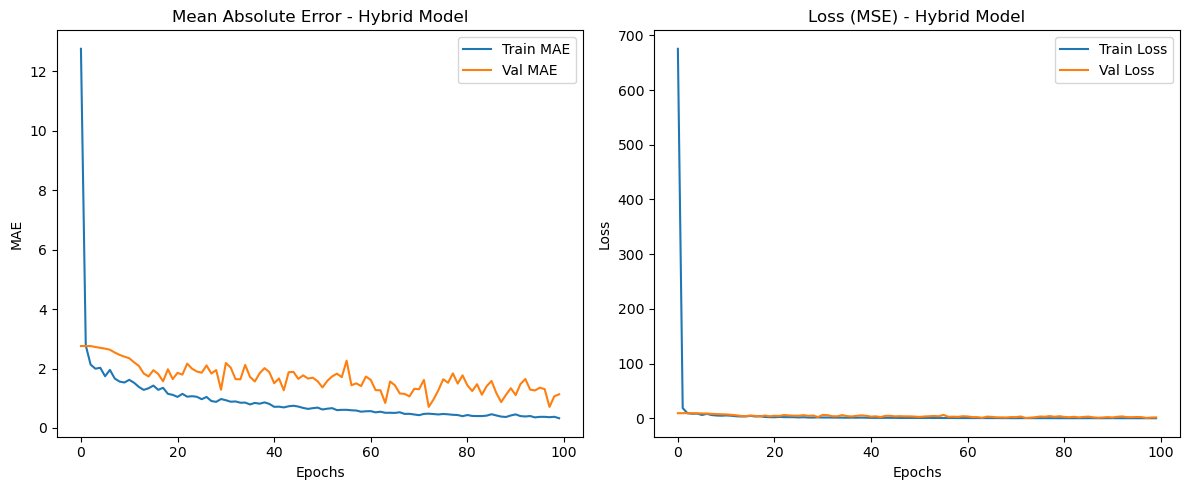

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical # Import to_categorical
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input,Dropout,GlobalMaxPooling2D, Conv2D, BatchNormalization,MaxPooling2D, Activation, DepthwiseConv2D, GlobalAveragePooling2D, Dense
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.regularizers import l2
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


'''Quantum crée pour chaque pixel un « descripteur » basé sur ses voisins, elle calcule des contributions dans 4 directions (0°, 45°, 90°, 135°), elle applique des poids par filtre sur ces contributions et elle combine tout et sort un feature map.
L’idée est de mimer une interaction entre pixels, un peu comme un effet d’interférence ou de propagation d’onde (d’où « quantum »).'''

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_filters, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_filters = num_filters  # Number of filters for the layer

    def build(self, input_shape):
        input_channels = input_shape[-1]  # Number of input channels

        # Initialize trainable weights for the influence of neighbors for each filter
        self.directional_weights = self.add_weight(
            shape=(self.num_filters, input_channels, 4),  # One weight per neighbor per channel for each filter
            initializer='random_normal',
            trainable=True,
            name='directional_weights'
        )

        # Initialize bias for each filter
        self.bias = self.add_weight(
            shape=(self.num_filters,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        # # Initialize a global scaling factor k for each filter
        self.global_k = self.add_weight(
            shape=(self.num_filters,),
            initializer='ones',
            trainable=True,
            name='global_k'
        )
    def call(self, inputs):
        # Ensure inputs are 4D tensor (batch_size, height, width, channels)
        if len(inputs.shape) != 4:
            raise ValueError("Input should be a 4D tensor (batch_size, height, width, channels)")

        # Padding to handle edges
        padded_inputs = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')

        # Extract neighbors
        neighbors = tf.stack([
            padded_inputs[:, :-2, 1:-1, :],  # top
            padded_inputs[:, 2:, 1:-1, :],  # bottom
            padded_inputs[:, 1:-1, :-2, :],  # left
            padded_inputs[:, 1:-1, 2:, :],  # right
            padded_inputs[:, :-2, :-2, :],  # top-left
            padded_inputs[:, :-2, 2:, :],  # top-right
            padded_inputs[:, 2:, :-2, :],  # bottom-left
            padded_inputs[:, 2:, 2:, :]   # bottom-right
        ], axis=-1)  # Shape: (batch_size, height, width, input_channels, 8)

        # Compute directional contributions
        p_0 = tf.abs(inputs * (1 - neighbors[..., 2] * neighbors[..., 3]))  # Horizontal (left-right)
        p_45 = tf.abs(inputs * (1 - neighbors[..., 4] * neighbors[..., 5]))  # Diagonal (top-left to bottom-right)
        p_90 = tf.abs(inputs * (1 - neighbors[..., 0] * neighbors[..., 1]))  # Vertical (top-bottom)
        p_135 = tf.abs(inputs * (1 - neighbors[..., 6] * neighbors[..., 7]))  # Diagonal (bottom-left to top-right)

        # Stack directional contributions
        directional_contributions = tf.stack([p_0, p_45, p_90, p_135], axis=-1)  # Shape: (batch_size, height, width, input_channels, 4)

        # Apply weights for each filter
        weighted_contributions = tf.einsum('bhwci,fci->bhwfi', directional_contributions, self.directional_weights)
        # Shape: (batch_size, height, width, num_filters, 4)

        # Take max across the 4 directions for each filter
        neighbor_contribution = tf.reduce_max(weighted_contributions, axis=-1)  # Shape: (batch_size, height, width, num_filters)

        feature_maps = self.global_k*neighbor_contribution+self.bias # Shape: (batch_size, height, width, num_filters)

        return feature_maps  # Output shape: (batch_size, height, width, num_filters)

    def get_config(self):
        config = super(QuantumLayer, self).get_config()
        config.update({
            'num_filters': self.num_filters,
            'stride': self.stride
            #'batch_shape': self.batch_shape
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

output_dir = "quantumlayer16/new"
os.makedirs(output_dir, exist_ok=True)
# Load and prepare data (if not already done)
# Assuming x_train, y_train, x_test, y_test are loaded here as before
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0



# Definition de l'entrée
input_layer = Input(shape=(512, 512, 3))

# Bloc 1 - parallèle
cnn_1 = Conv2D(8, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(1e-4))(input_layer)
cnn_1 = MaxPooling2D((2, 2))(cnn_1)
quantum_1 = QuantumLayer(num_filters=8)(input_layer)
quantum_1 = MaxPooling2D((2, 2))(quantum_1)

# Fusion |Δ| 1
merged_1 = Concatenate()([cnn_1, quantum_1])

# Bloc 2
cnn_2 = Conv2D(16, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(1e-4) )(merged_1)
cnn_2 = MaxPooling2D((2, 2))(cnn_2)
quantum_2 = QuantumLayer(num_filters=16)(merged_1)
quantum_2 = MaxPooling2D((2, 2))(quantum_2)

# Fusion |Δ| 2
merged_2 = Concatenate()([cnn_2, quantum_2])

# Bloc 3
cnn_3 = Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(merged_2)
cnn_3 = BatchNormalization()(cnn_3)
cnn_3 = Activation('relu')(cnn_3)
cnn_3 = MaxPooling2D((2, 2))(cnn_3)
cnn_3 = Dropout(0.25)(cnn_3)
quantum_3 = QuantumLayer(num_filters=32)(merged_2)
quantum_3 = MaxPooling2D((2, 2))(quantum_3)

# Fusion |Δ| 3
merged_3 = Concatenate()([cnn_3, quantum_3])

# Bloc 4
cnn_4 = Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(merged_3)
cnn_4 = BatchNormalization()(cnn_4)
cnn_4 = Activation('relu')(cnn_4)
cnn_4 = MaxPooling2D((2, 2))(cnn_4)
cnn_4 = Dropout(0.25)(cnn_4)
quantum_4 = QuantumLayer(num_filters=64)(merged_3)
quantum_4 = MaxPooling2D((2, 2))(quantum_4)

# Fusion |Δ| 4
merged_4 = Concatenate()([cnn_4, quantum_4])

# Bloc 5
cnn_5 = Conv2D(128, (7, 7), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(merged_4)
cnn_5 = BatchNormalization()(cnn_5)
cnn_5 = Activation('relu')(cnn_5)
cnn_5 = MaxPooling2D((2, 2))(cnn_5)
cnn_5 = Dropout(0.25)(cnn_5)
quantum_5 = QuantumLayer(num_filters=128)(merged_4)
quantum_5 = MaxPooling2D((2, 2))(quantum_5)

# Fusion |Δ| 5
merged_5 = Concatenate()([cnn_5, quantum_5])

# Global pooling et dense
global_pool = GlobalMaxPooling2D()(merged_5)
output = Dense(1, activation='linear')(global_pool)  # continuous output

# Model
model_hybrid = Model(inputs=input_layer, outputs=output)

# Compile for regression
model_hybrid.compile(optimizer='adam', loss='mse', metrics=['mae'])  # mse loss + mae metric

# Training (assuming train_ds_img yields (image, label) with label float LAI)
history_hybrid = model_hybrid.fit(
    train_ds_img,
    epochs=100,
    batch_size=64,
    validation_data=val_ds_img
)

# Plot history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['mae'], label='Train MAE')
plt.plot(history_hybrid.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error - Hybrid Model')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) - Hybrid Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
# Evaluate loss and MAE
# Evaluate on test data
test_loss, test_acc = model_hybrid.evaluate(test_ds_img, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 2.0853 - mae: 1.2469
Test Loss: 2.0274
Test Accuracy: 1.2084


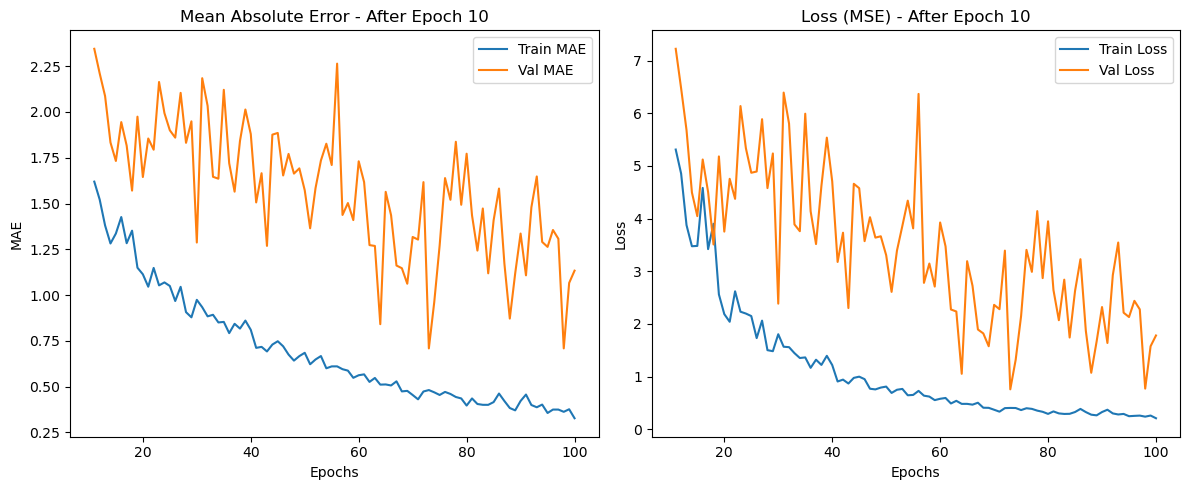

In [54]:
# Plot AFTER epoch 10
start_epoch = 10  # 0-based index, so this starts at epoch 11

plt.figure(figsize=(12, 5))

# --- MAE ---
plt.subplot(1, 2, 1)
plt.plot(range(start_epoch+1, len(history_hybrid.history['mae'])+1), 
         history_hybrid.history['mae'][start_epoch:], label='Train MAE')
plt.plot(range(start_epoch+1, len(history_hybrid.history['val_mae'])+1), 
         history_hybrid.history['val_mae'][start_epoch:], label='Val MAE')
plt.title(f'Mean Absolute Error - After Epoch {start_epoch}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(range(start_epoch+1, len(history_hybrid.history['loss'])+1), 
         history_hybrid.history['loss'][start_epoch:], label='Train Loss')
plt.plot(range(start_epoch+1, len(history_hybrid.history['val_loss'])+1), 
         history_hybrid.history['val_loss'][start_epoch:], label='Val Loss')
plt.title(f'Loss (MSE) - After Epoch {start_epoch}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
